<a href="https://colab.research.google.com/github/ariahosseini/ThermoElectric/blob/master/ElectronTransport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [1]:
# Libs
import os
from itertools import product
from copy import deepcopy
from tqdm import tqdm
from os.path import expanduser
# Colab
from google.colab import drive
# Math
import numpy as np
from math import pi, atan, exp, gamma, sqrt
from numpy.linalg import norm
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
from scipy.interpolate import PchipInterpolator as Interpolator
from scipy.special import jv, j1 as besselj
from scipy.integrate import trapz
# Vis
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set a style
plt.style.use('seaborn')

<ipython-input-2-5e09d57c14a7>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# Set up Seaborn visualization style
sns.set()
sns.set_style("white", {"xtick.major.size": 2, "ytick.major.size": 2})
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 4})

In [4]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Working directory
os.chdir("/content/drive/MyDrive/ThermoElectric/Nanocomposite")

Constants

In [6]:
e2C = 1.6021765e-19   # Elementary charge in Coulombs
eV2J = 1.60218e-19    # Convert eV to Joules
h_bar = 6.582119e-16  # Reduced Planck constant in eV.s
k_B = 8.617330350e-5  # Boltzmann constant in eV/K
ang2meter = 1e-10     # Convert Angestrom to meter
permittivity_vacuum = 8.854187817e-12  # Permittivity in vacuum (F/m)
electron_mass = 9.10938356e-31  # Electron rest mass (kg)

## Funcs

### Fermi Integral

In [7]:
def fermi(aj, eta):

    """
    Python version of the half-order Fermi-Dirac integral evaluation.
    Based on the publication:
    'The accurate numerical evaluation of half-order Fermi-Dirac integrals'
    by N.Mohankumar & A.Natarajan, Physica Status Solidi(b), vol.188, 1995, pp. 635-644.

    Parameters:
        aj (float): The value corresponding to j= -1/2 or 1/2 or 3/2 or 5/2 in the integral definition.
        eta (float): Input parameter for the integral often between -5 to 25.

    Returns:
        fdp (float): The calculated Fermi-Dirac integral value.
        nmax (int): The number of trapezoidal points used.
        npole (int): The number of poles used in the correction.
    """

    range_val = 8.0
    if eta > 0:
        range_val = sqrt(eta + 64.0)

    h = 0.5
    nmax = int(range_val / h)
    summation = 0.0

    if aj == -0.5:
        summation = 1.0 / (1.0 + exp(-eta))

    for i in range(1, nmax + 1):
        u = i * h
        ff = 2.0 * (u ** (2.0 * aj + 1.0)) / (1.0 + exp(u ** 2 - eta))
        summation += ff

    pol = 0.0
    npole = 0
    bk1 = 0

    while bk1 <= 14.0 * pi:
        npole += 1
        bk = (2 * npole - 1) * pi
        rho = sqrt(eta * eta + bk * bk)
        tk = 0

        if eta < 0:
            tk = -aj * (atan(-bk / eta) + pi)
        elif eta == 0:
            tk = 0.5 * pi * aj
        elif eta > 0:
            tk = aj * atan(bk / eta)

        rk = -(rho ** aj)
        if eta < 0:
            rk = -rk

        ak = (2.0 * pi / h) * sqrt(0.5 * (rho + eta))
        bk1 = (2.0 * pi / h) * sqrt(0.5 * (rho - eta))

        if bk1 <= 14.0 * pi:
            gama = exp(bk1)
            t1 = gama * np.sin(ak + tk) - np.sin(tk)
            t2 = 1.0 - 2.0 * gama * np.cos(ak) + gama * gama
            pol += 4.0 * pi * rk * t1 / t2

    fdp = summation * h + pol

    # print("Fermi-Dirac Integral Value:", fdp / gamma(1 + aj))
    # print("Number of trapezoidal points & number of poles:", nmax, npole - 1)

    return fdp / gamma(1 + aj)

### Accumulation Function

In [8]:
def accum(accmap, a, func=None, size=None, fill_value=0, dtype=None):

    """
    An accumulation function similar to Matlab's `accumarray` function.

    Parameters
    ----------
    accmap : ndarray
        This is the "accumulation map".  It maps input (i.e. indices into
        `a`) to their destination in the output array.  The first `a.ndim`
        dimensions of `accmap` must be the same as `a.shape`.  That is,
        `accmap.shape[:a.ndim]` must equal `a.shape`.  For example, if `a`
        has shape (15,4), then `accmap.shape[:2]` must equal (15,4).  In this
        case `accmap[i,j]` gives the index into the output array where
        element (i,j) of `a` is to be accumulated.  If the output is, say,
        a 2D, then `accmap` must have shape (15,4,2).  The value in the
        last dimension give indices into the output array. If the output is
        1D, then the shape of `accmap` can be either (15,4) or (15,4,1)
    a : ndarray
        The input data to be accumulated.
    func : callable or None
        The accumulation function.  The function will be passed a list
        of values from `a` to be accumulated.
        If None, numpy.sum is assumed.
    size : ndarray or None
        The size of the output array.  If None, the size will be determined
        from `accmap`.
    fill_value : scalar
        The default value for elements of the output array.
    dtype : numpy data type, or None
        The data type of the output array.  If None, the data type of
        `a` is used.

    Returns
    -------
    out : ndarray
        The accumulated results.

        The shape of `out` is `size` if `size` is given.  Otherwise the
        shape is determined by the (lexicographically) largest indices of
        the output found in `accmap`.


    Examples
    --------
    >>> from numpy import array, prod
    >>> a = array([[1,2,3],[4,-1,6],[-1,8,9]])
    >>> a
    array([[ 1,  2,  3],
           [ 4, -1,  6],
           [-1,  8,  9]])
    >>> # Sum the diagonals.
    >>> accmap = array([[0,1,2],[2,0,1],[1,2,0]])
    >>> s = accum(accmap, a)
    array([9, 7, 15])
    >>> # A 2D output, from sub-arrays with shapes and positions like this:
    >>> # [ (2,2) (2,1)]
    >>> # [ (1,2) (1,1)]
    >>> accmap = array([
            [[0,0],[0,0],[0,1]],
            [[0,0],[0,0],[0,1]],
            [[1,0],[1,0],[1,1]],
        ])
    >>> # Accumulate using a product.
    >>> accum(accmap, a, func=prod, dtype=float)
    array([[ -8.,  18.],
           [ -8.,   9.]])
    >>> # Same accmap, but create an array of lists of values.
    >>> accum(accmap, a, func=lambda x: x, dtype='O')
    array([[[1, 2, 4, -1], [3, 6]],
           [[-1, 8], [9]]], dtype=object)
    """

    # Check for bad arguments and handle the defaults.
    if accmap.shape[:a.ndim] != a.shape:
        raise ValueError("The initial dimensions of accmap must be the same as a.shape")
    if func is None:
        func = np.sum
    if dtype is None:
        dtype = a.dtype
    if accmap.shape == a.shape:
        accmap = np.expand_dims(accmap, -1)
    adims = tuple(range(a.ndim))
    if size is None:
        size = 1 + np.squeeze(np.apply_over_axes(np.max, accmap, axes=adims))
    size = np.atleast_1d(size)

    # Create an array of python lists of values.
    vals = np.empty(size, dtype='O')
    for s in product(*[range(k) for k in size]):
        vals[s] = []
    for s in product(*[range(k) for k in a.shape]):
        indx = tuple(accmap[s])
        val = a[s]
        vals[indx].append(val)

    # Create the output array.
    out = np.empty(size, dtype=dtype)
    for s in product(*[range(k) for k in size]):
        if vals[s] == []:
            out[s] = fill_value
        else:
            out[s] = func(vals[s])

    return out

### BTE Solver

#### Electrical Properties

In [9]:
def electrical_properties(E: np.ndarray, DoS: np.ndarray, vg: np.ndarray, Ef: np.ndarray,
                          dfdE: np.ndarray, temp: np.ndarray, tau: np.ndarray) -> dict:
    """
    Computes the electronic properties using the Boltzmann Transport Equation (BTE).

    References:
    -----------
    - Changwook Jeong and Mark S. Lundstrom, "Near-equilibrium Transport: Fundamentals and Applications"
    - Gang Chen, "Nanoscale Energy Transport and Conversion: A Parallel Treatment of Electrons, Molecules, Phonons, and Photons"

    Parameters:
    -----------
    E : np.ndarray
        Energy range (eV)
    DoS : np.ndarray
        Density of states (states/eV)
    vg : np.ndarray
        Group velocity (m/s)
    Ef : np.ndarray
        Fermi level (eV)
    dfdE : np.ndarray
        Fermi-Dirac derivative
    temp : np.ndarray
        Temperature (K)
    tau : np.ndarray
        Relaxation time (s)

    Returns:
    --------
    dict
        Contains electrical conductivity, Seebeck coefficient, power factor, thermal conductivity, and Lorenz number.
    """

    # Precompute useful terms
    X = DoS * vg ** 2 * dfdE  # χ (Chi)
    Y = (E - Ef.T) * X  # Γ (Gamma)
    Z = (E - Ef.T) * Y  # ζ (Zeta)

    # Transport properties
    Sigma = -np.trapz(X * tau, E, axis=1) / 3 * e2C  # Electrical conductivity (S/m)
    S = -np.trapz(Y * tau, E, axis=1) / np.trapz(X * tau, E, axis=1) / temp  # Seebeck coefficient (V/K)
    PF = Sigma * S ** 2  # Power factor (W/K²·m)
    ke = -1 * (np.trapz(Z * tau, E, axis=1) - np.trapz(Y * tau, E, axis=1) ** 2 /
               np.trapz(X * tau, E, axis=1)) / temp / 3 * e2C  # Thermal conductivity (W/m·K)

    # Lorenz number
    delta = np.trapz(X * tau * E, E, axis=1) / np.trapz(X * tau, E, axis=1)  # First moment of current
    delta_ = np.trapz(X * tau * E ** 2, E, axis=1) / np.trapz(X * tau, E, axis=1)  # Second moment of current
    Lorenz = (delta_ - delta ** 2) / temp**2  # Lorenz number (WΩ/K²)

    return {
        'Electrical_conductivity': Sigma,
        'Seebeck_coefficient': S[0],
        'Power_factor': PF[0],
        'Thermal_conductivity': ke[0],
        'Lorenz_number': Lorenz[0]
    }

#### Filtering Effect

In [10]:
def filtering_effect(Uo: np.ndarray, E: np.ndarray, DoS: np.ndarray, vg: np.ndarray, Ef: np.ndarray,
                     dfdE: np.ndarray, temp: np.ndarray, tau_bulk: np.ndarray) -> dict:
    """
    Calculates the electrical properties under ideal filtering conditions, where all electrons
    up to a cutoff energy Uo are blocked.

    Parameters:
    -----------
    Uo : np.ndarray
        Barrier height (eV)
    E : np.ndarray
        Energy range (eV)
    DoS : np.ndarray
        Density of states (states/eV)
    vg : np.ndarray
        Group velocity (m/s)
    Ef : np.ndarray
        Fermi level (eV)
    dfdE : np.ndarray
        Fermi-Dirac derivative
    temp : np.ndarray
        Temperature (K)
    tau_bulk : np.ndarray
        Bulk relaxation time (s)

    Returns:
    --------
    dict
        Contains electrical conductivity and Seebeck coefficient.
    """
    tau_Uo = np.ones(E.shape[1])
    Conductivity, Seebeck = [], []

    for uo in Uo:
        tau_filtered = deepcopy(tau_Uo)
        tau_filtered[E[0] < uo] = 0  # Apply ideal filtering

        tau = matthiessen(E, tau_filtered, tau_bulk)  # Compute total relaxation time
        coefficients = electrical_properties(E, DoS, vg, Ef, dfdE, temp, tau)

        Conductivity.append(coefficients['Electrical_conductivity'])
        Seebeck.append(coefficients['Seebeck_coefficient'])

    return {
        'Electrical_conductivity': np.array(Conductivity),
        'Seebeck_coefficient': np.array(Seebeck)
    }

#### Phenomenological Model

In [11]:
def phenomenological(Uo: np.ndarray, tau_o: np.ndarray, E: np.ndarray, DoS: np.ndarray, vg: np.ndarray,
                     Ef: np.ndarray, dfdE: np.ndarray, temp: np.ndarray, tau_bulk: np.ndarray) -> dict:
    """
    Calculates the electrical properties with phenomenological filtering, where a lifetime tau_o
    is imposed up to a cutoff energy Uo.

    Parameters:
    -----------
    Uo : np.ndarray
        Barrier height (eV)
    tau_o : np.ndarray
        Phenomenological lifetime (s)
    E : np.ndarray
        Energy range (eV)
    DoS : np.ndarray
        Density of states (states/eV)
    vg : np.ndarray
        Group velocity (m/s)
    Ef : np.ndarray
        Fermi level (eV)
    dfdE : np.ndarray
        Fermi-Dirac derivative
    temp : np.ndarray
        Temperature (K)
    tau_bulk : np.ndarray
        Bulk relaxation time (s)

    Returns:
    --------
    dict
        Contains electrical conductivity and Seebeck coefficient.
    """
    tau_Uo = np.ones(E.shape[1])
    Conductivity, Seebeck = [], []

    for tau in tau_o:
        for uo in Uo:
            tau_ph = deepcopy(tau_Uo)
            tau_ph[E[0] < uo] = tau  # Apply phenomenological filtering

            total_tau = matthiessen(E, tau_ph, tau_bulk)
            coefficients = electrical_properties(E, DoS, vg, Ef, dfdE, temp, total_tau)

            Conductivity.append(coefficients['Electrical_conductivity'])
            Seebeck.append(coefficients['Seebeck_coefficient'])

    return {
        'Electrical_conductivity': np.array(Conductivity).reshape(len(tau_o), len(Uo)),
        'Seebeck_coefficient': np.array(Seebeck).reshape(len(tau_o), len(Uo))
    }


### Extra Functions

#### Band Gap

In [12]:
def band_gap(Eg_0: float, A: float, B: float, temp: np.ndarray = None) -> np.ndarray:
    """
    Estimate the temperature-dependent band gap using the relation:
    Eg(T) = Eg(T=0) - A * T^2 / (T + B)

    Reference: "Properties of Advanced Semiconductor Materials" by Michael E. Levinshtein.

    Parameters
    ----------
    Eg_0: float
        Band gap at 0 Kelvin.
    A: float
        Material-dependent constant.
    B: float
        Material-dependent constant.
    temp: np.ndarray, optional
        Temperature range (default: 300K to 1300K with steps of 100K).

    Returns
    -------
    np.ndarray
        Temperature-dependent band gap.
    """
    T = temp if temp is not None else temperature()
    return Eg_0 - A * (T ** 2) / (T + B)

#### Density of State

In [13]:
def analytical_dos(energy_range: np.ndarray, m_eff: float, alpha: np.ndarray) -> dict:
    """
    Compute the electron density of states (DoS) for parabolic and non-parabolic bands.

    Parameters
    ----------
    energy_range: np.ndarray
        Range of electron energies.
    m_eff: float
        Effective mass of the electron.
    alpha: np.ndarray
        Non-parabolicity parameter.

    Returns
    -------
    dict
        DoS for both parabolic and non-parabolic cases.
    """

    # Non-parabolic and parabolic DoS calculation
    dos_nonparabolic = (1 / np.pi ** 2) * np.sqrt(2 * energy_range * (1 + energy_range * alpha.T)) * \
                       (m_eff ** (3/2)) / (h_bar ** 3) * (1 + 2 * energy_range * alpha.T) / e2C ** (3/2)

    dos_parabolic = np.sqrt(energy_range) / (np.pi ** 2) * np.sqrt(2) / (h_bar ** 3) * \
                    m_eff ** (3 / 2) / e2C ** (3 / 2)

    return {'DoS_nonparabolic': dos_nonparabolic, 'DoS_parabolic': dos_parabolic}

#### Fermi Level

In [14]:
def fermi_level(carrier: np.ndarray, energy: np.ndarray, density: np.ndarray, Nc: float = None,
                A: float = None, temp: np.ndarray = None) -> np.ndarray:
    """
    Estimate the Fermi level using Joyce-Dixon approximation.
    Ref: "Principles of Semiconductor Devices" by Sima Dimitrijev

    Parameters
    ----------
    carrier: np.ndarray
        Carrier concentration.
    energy: np.ndarray
        Energy levels.
    density: np.ndarray
        Density of states.
    Nc: float, optional
        Effective density of states in the conduction band.
    A: float, optional
        Experimentally fitted parameter (Nc ~ A * T^(3/2)).
    temp: np.ndarray, optional
        Temperature range.

    Returns
    -------
    np.ndarray
        Carrier concentration and Fermi level at each temperature.
    """
    T = temp if temp is not None else temperature()

    if Nc is None and A is None:
        raise ValueError("Either Nc or A must be provided.")

    Nc = Nc if Nc is not None else A * T ** (3 / 2)

    # Joyce-Dixon approximation
    JD_CC = np.log(carrier / Nc) + carrier / Nc / np.sqrt(8) - (3 / 16 - np.sqrt(3) / 9) * (carrier / Nc) ** 2
    fermi_energy = k_B * T * JD_CC
    f, _ = fermi_distribution(energy, fermi_energy, temp=T)

    carrier_concentration = np.trapz(density * f, energy, axis=1)

    return np.stack((carrier_concentration, fermi_energy[0]))

In [15]:
def fermi_self_consistent(carrier: np.ndarray, temp: np.ndarray, energy: np.ndarray,
                          density: np.ndarray, fermi_guess: np.ndarray) -> np.ndarray:
    """
    Perform self-consistent calculation of the Fermi level using a given carrier concentration.
    Defaults: 4000 sampling points in energy range from Ef(JD)-0.4 [eV] up to
    Ef(JD)+0.2 [eV] - This looks reasonable in most cases.
    The index is printed out if indices reach the extreme value of (0) or (4000), increase energy range.

    Parameters
    ----------
    carrier: np.ndarray
        Carrier concentration.
    energy: np.ndarray
        Energy levels.
    density: np.ndarray
        Density of states.
    fermi_guess: np.ndarray
        Initial Fermi level guess from Joyce-Dixon approximation.
    temp: np.ndarray
        Temperature range.

    Returns
    -------
    np.ndarray
        Carrier concentration and Fermi level.
    """
    fermi = np.linspace(fermi_guess[1] - 0.4, fermi_guess[1] + 0.2, 2000)
    result = np.empty((np.shape(temp)[1], np.shape(fermi)[0]))

    for j, t in tqdm(enumerate(temp[0]), total=len(temp[0]), desc="Processing temperatures"):
        for i, f in tqdm(enumerate(fermi[:, j]), total=len(fermi[:, j]), desc=f"Processing fermi levels for temp {t} K", leave=False):
            f_dist, _ = fermi_distribution(energy, np.array([f]), np.array([t]))
            result[j, i] = np.trapz(density * f_dist, energy, axis=1)
    diff = np.tile(carrier.T, (1, np.shape(fermi)[0])) - abs(result)
    min_idx = np.argmin(np.abs(diff), axis=1)

    if np.all(np.array(min_idx) == 0) or np.all(np.array(min_idx) == int(np.shape(fermi)[0]-1)):
            print(f"Self-consistent Fermi Level Diverged! Please increase energy range or number of sampling points")

    fermi_levels = []

    for i in range(np.shape(temp)[1]):
      fermi_levels.append(fermi[min_idx[i], i])

    return np.stack((carrier[0], fermi_levels))

#### Group Velocity

In [16]:
def group_velocity(kpoints: np.ndarray, energy_kp: np.ndarray, energy: np.ndarray) -> np.ndarray:
    """
    Compute group velocity from band structure using DFT data.
    Reciprocal lattice vector is required.
    Linear BTE needs single band data.

    Parameters
    ----------
    kpoints: np.ndarray
        Wave vectors.
    energy_kp: np.ndarray
        Energy for each wave vector.
    energy: np.ndarray
        Energy range.

    Returns
    -------
    np.ndarray
        Group velocity.
    """

    dE_dk = np.zeros_like(energy_kp)
    for i in range(1, len(energy_kp) - 1):
        h1 = kpoints[i] - kpoints[i-1]   # Step size between k[i] and k[i-1]
        h2 = kpoints[i+1] - kpoints[i]   # Step size between k[i+1] and k[i]

        dE_dk[i] = (energy_kp[i+1] - energy_kp[i-1]) / (h1 + h2) + \
                   ((energy_kp[i+1] - energy_kp[i]) * h1 - (energy_kp[i] - energy_kp[i-1]) * h2) / (h1 * h2 * (h1 + h2))

    # Forward difference for the first point
    h1 = kpoints[1] - kpoints[0]
    h2 = kpoints[2] - kpoints[1]
    dE_dk[0] = (energy_kp[1] - energy_kp[0]) / h1 + ((energy_kp[2] - energy_kp[1]) * (h1 + h2) - (energy_kp[1] - energy_kp[0]) * h2) / (h1 * (h1 + h2))

    # Backward difference for the last point
    h1 = kpoints[-1] - kpoints[-2]
    h2 = kpoints[-2] - kpoints[-3]
    dE_dk[-1] = (energy_kp[-1] - energy_kp[-2]) / h1 + ((energy_kp[-1] - energy_kp[-2]) * (h1 + h2) - (energy_kp[-2] - energy_kp[-3]) * h2) / (h1 * (h1 + h2))

    velocity_spline = Spline(energy_kp, dE_dk)
    velocity_function = velocity_spline(energy)

    return velocity_function / h_bar

In [17]:
def analytical_group_velocity(energy: np.ndarray, lattice_param: np.ndarray, num_kpoints: np.ndarray,
                              m_eff: np.ndarray, valley: np.ndarray, dk_len: np.ndarray,
                              alpha_term: np.ndarray) -> np.ndarray:
    """
    Approximate group velocity for conduction bands near the band edge.

    Parameters
    ----------
    energy: np.ndarray
        Energy range.
    lattice_param: np.ndarray
        Lattice parameter.
    num_kpoints: np.ndarray
        Number of k-points.
    m_eff: np.ndarray
        Effective mass along axes.
    valley: np.ndarray
        Conduction band valley.
    dk_len: np.ndarray
        Wave vector magnitude.
    alpha_term: np.ndarray
        Non-parabolicity term.

    Returns
    -------
    np.ndarray
        Group velocity.
    """
    k0 = 2 * np.pi / lattice_param * valley
    del_k = 2 * np.pi / lattice_param * dk_len * np.ones(3)

    kx = np.linspace(k0[0], k0[0] + del_k[0], num_kpoints[0])
    ky = np.linspace(k0[1], k0[1] + del_k[1], num_kpoints[1])
    kz = np.linspace(k0[2], k0[2] + del_k[2], num_kpoints[2])

    kpoints = np.meshgrid(kx, ky, kz)
    kpoints = np.vstack([k.flatten() for k in kpoints])

    m_eff_cond = 3 / np.sum(1 / m_eff)

    E = h_bar**2 / (2 * m_eff_cond) * np.sum([(kpoints[i] - k0[i]) ** 2 for i in range(3)], axis=0) * e2C
    vel = h_bar * np.sqrt(np.sum([(kpoints[i] - k0[i]) ** 2 for i in range(3)], axis=0)) / m_eff_cond * e2C

    gv_spline = Spline(E, vel)
    gv_function = gv_spline(energy)

    return gv_function

### Lifetimes

#### Ellipsoid

In [18]:
def ellipsoid(xc, yc, zc, xr, yr, zr, n):
    """
    generates the x, y, z coordinates of an ellipsoid surface.

    Parameters:
    xc, yc, zc : float
        The center of the ellipsoid.
    xr, yr, zr : float
        The radii along the x, y, and z axes.
    n : int
        The number of divisions along the grid.
    returns:
    x, y, z : ndarray
        the meshgrid arrays representing the ellipsoid surface
    """
    # Create a meshgrid in spherical coordinates (theta, phi)
    u = np.linspace(-np.pi, np.pi, n+1)     # theta from -pi to pi
    v = np.linspace(0, np.pi, n+1)         # phi from 0 to pi

    u, v = np.meshgrid(u, v)

    # Parametric equations for the ellipsoid
    x = xc + xr * np.cos(u) * np.sin(v)
    y = yc + yr * np.sin(u) * np.sin(v)
    z = zc + zr * np.cos(v)

    # fig = plt.figure(figsize=(8, 6))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(x, y, z, rstride=4, cstride=4, color='b', alpha=0.6, edgecolor='k')
    # ax.set_xlabel('kx')
    # ax.set_ylabel('ky')
    # ax.set_zlabel('kz')
    # ax.set_xlim([-xr, xr])
    # ax.set_ylim([-yr, yr])
    # ax.set_zlim([-zr, zr])
    # plt.show()
    return x, y, z[::-1] # Negative sign is consistant with Matlab ellipsoid func

#### Refactor Scattering Calculations

In [19]:
def generate_kpoints(ko, del_k, nk):
    """
    Generate k-points in 3D space and compute their magnitudes.

    Parameters:
    -----------
    ko : list or array
        The initial k-point (kx, ky, kz) in 3D space.
    del_k : list or array
        The step sizes for each k-point component (kx, ky, kz).
    nk : list or array
        The number of points to generate along each k-point direction (kx, ky, kz).

    Returns:
    --------
    kpoint : ndarray
        A 2D array where each row represents a k-point (kx, ky, kz).
    mag_kpoint : ndarray
        A 1D array containing the magnitudes of each k-point vector.
    """

    kx = np.linspace(ko[0], ko[0] + del_k[0], nk[0])
    ky = np.linspace(ko[1], ko[1] + del_k[1], nk[1])
    kz = np.linspace(ko[2], ko[2] + del_k[2], nk[2])

    xk, yk, zk = np.meshgrid(kx, ky, kz, indexing='ij')
    kpoints = np.column_stack((xk.ravel(), yk.ravel(), zk.ravel()))
    mag_kpoint = np.linalg.norm(kpoints, axis=1)

    return kpoints, mag_kpoint

In [20]:
def calculate_energy(kpoints, ko, m):
    """
    Calculate the energy for a set of k-points using a quadratic dispersion relation.

    Parameters:
    -----------
    kpoints : ndarray
        A 2D array where each row represents a k-point (kx, ky, kz).
    ko : list or array
        The reference k-point (ko_x, ko_y, ko_z).
    m : list or array
        The effective masses (mx, my, mz) along each k-point direction.
    h_bar : float
        Reduced Planck's constant (ħ).
    eV2J : float
        Conversion factor from electron volts to joules.

    Returns:
    --------
    E : ndarray
        A 1D array of energies corresponding to each k-point.
    """

    # Energy (J) calculation
    E = (h_bar**2 / 2) * (
            (kpoints[:, 0] - ko[0])**2 / m[0] +
            (kpoints[:, 1] - ko[1])**2 / m[1] +
            (kpoints[:, 2] - ko[2])**2 / m[2]
        ) * eV2J

    return E

In [21]:
def calculate_centroids_and_areas(x, y, z, n):
    """
    Calculate centroids and surface areas for triangular facets defined by the (x, y, z) coordinates.

    Parameters:
    -----------
    x, y, z : 2D ndarray
        Arrays containing the x, y, z coordinates of the mesh points.
    n : int
        Number of divisions in the grid.

    Returns:
    --------
    Q : ndarray
        Centroid coordinates of each triangle.
    A : ndarray
        Surface area of each triangle.
    """

    # Initialize arrays for centroids (Q) and areas (A)
    Q = np.zeros((2*n*(n-1), 3))
    A = np.zeros((2*n*(n-1), 1))
    k = 0

    for j in range(1, n):
      for i in range(2, n+1):
        S = np.array([x[i, j], y[i, j], z[i, j]]) + \
            np.array([x[i-1, j], y[i-1, j], z[i-1, j]]) + \
            np.array([x[i-1, j-1], y[i-1, j-1], z[i-1, j-1]])
        # Centroid
        Q[k, :] = S / 3
        # Surface area
        a = np.linalg.norm(np.array([x[i, j], y[i, j], z[i, j]]) - np.array([x[i-1, j], y[i-1, j], z[i-1, j]]))
        b = np.linalg.norm(np.array([x[i-1, j], y[i-1, j], z[i-1, j]]) - np.array([x[i-1, j-1], y[i-1, j-1], z[i-1, j-1]]))
        c = np.linalg.norm(np.array([x[i-1, j-1], y[i-1, j-1], z[i-1, j-1]]) - np.array([x[i, j], y[i, j], z[i, j]]))
        s = (a + b + c) / 2
        A[k, 0] = np.sqrt(s * (s - a) * (s - b) * (s - c))
        k += 1

    for j in range(1, n):
      for i in range(1, n):
        S = np.array([x[i, j-1], y[i, j-1], z[i, j-1]]) + \
            np.array([x[i, j], y[i, j], z[i, j]]) + \
            np.array([x[i-1, j-1], y[i-1, j-1], z[i-1, j-1]])
        # Centroid
        Q[k, :] = S / 3
        # Surface area
        a = np.linalg.norm(np.array([x[i, j-1], y[i, j-1], z[i, j-1]]) - np.array([x[i, j], y[i, j], z[i, j]]))
        b = np.linalg.norm(np.array([x[i, j], y[i, j], z[i, j]]) - np.array([x[i-1, j-1], y[i-1, j-1], z[i-1, j-1]]))
        c = np.linalg.norm(np.array([x[i-1, j-1], y[i-1, j-1], z[i-1, j-1]]) - np.array([x[i, j-1], y[i, j-1], z[i, j-1]]))
        s = (a + b + c) / 2
        A[k, 0] = np.sqrt(s * (s - a) * (s - b) * (s - c))
        k += 1

    for i in range(2, n+1):
      S = np.array([x[i, 0], y[i, 0], z[i, 0]]) + \
          np.array([x[i-1, 0], y[i-1, 0], z[i-1, 0]]) + \
          np.array([x[i-1, -2], y[i-1, -2], z[i-1, -2]])
      # Centroid
      Q[k, :] = S / 3
      # Surface area
      a = np.linalg.norm(np.array([x[i, 0], y[i, 0], z[i, 0]]) - np.array([x[i-1, 0], y[i-1, 0], z[i-1, 0]]))
      b = np.linalg.norm(np.array([x[i-1, 0], y[i-1, 0], z[i-1, 0]]) - np.array([x[i-1, -2], y[i-1, -2], z[i-1, -2]]))
      c = np.linalg.norm(np.array([x[i-1, -2], y[i-1, -2], z[i-1, -2]]) - np.array([x[i, 0], y[i, 0], z[i, 0]]))
      s = (a + b + c) / 2
      A[k, 0] = np.sqrt(s * (s - a) * (s - b) * (s - c))
      k += 1

    for i in range(1, n):
      S = np.array([x[i, -2], y[i, -2], z[i, -2]]) + \
          np.array([x[i, 0], y[i, 0], z[i, 0]]) + \
          np.array([x[i-1, -2], y[i-1, -2], z[i-1, -2]])
      # Centroid
      Q[k, :] = S / 3
      # Surface area
      a = np.linalg.norm(np.array([x[i, -2], y[i, -2], z[i, -2]]) - np.array([x[i, 0], y[i, 0], z[i, 0]]))
      b = np.linalg.norm(np.array([x[i, 0], y[i, 0], z[i, 0]]) - np.array([x[i-1, -2], y[i-1, -2], z[i-1, -2]]))
      c = np.linalg.norm(np.array([x[i-1, -2], y[i-1, -2], z[i-1, -2]]) - np.array([x[i, -2], y[i, -2], z[i, -2]]))
      s = (a + b + c) / 2
      A[k, 0] = np.sqrt(s * (s - a) * (s - b) * (s - c))
      k += 1
    return Q, A

#### Phonon Lifetime

In [22]:
def calculate_phonon_lifetime(energy: np.ndarray, alpha_term: np.ndarray, D_v: float, D_a: float,
                              temperature: np.ndarray, sound_velocity: float, density_of_states: np.ndarray, mass_density: float) -> dict:
    """
    Calculate the electron-phonon scattering rate using the Ravich model.

    Parameters
    ----------
    energy : np.ndarray
        Energy range.
    alpha_term : np.ndarray
        Non-parabolic term.
    D_v : float
        Hole deformation potential.
    D_a : float
        Electron deformation potential.
    temperature : np.ndarray
        Temperature.
    sound_velocity : float
        Sound velocity.
    density_of_states : np.ndarray
        Density of states.
    mass_density : float
        Mass density.

    Returns
    -------
    dict
        Dictionary with 'parabolic_phonon_lifetime' and 'nonparabolic_phonon_lifetime'.
    """

    nonparabolic_term = (1 - ((alpha_term * energy) / (1 + 2 * alpha_term * energy) * (1 - D_v / D_a))) ** 2 \
                        - 8 / 3 * (alpha_term * energy) * (1 + alpha_term * energy) / (
                                    1 + 2 * alpha_term * energy) ** 2 * (D_v / D_a)

    tau_ph_parabolic = mass_density * sound_velocity ** 2 * h_bar \
          / (np.pi * k_B * temperature.T * D_a**2) * 1e9 / e2C / density_of_states  # Lifetime for parabolic band

    tau_ph_nonparabolic = tau_ph_parabolic / nonparabolic_term  # Lifetime in nonparabolic band

    return {'parabolic_phonon_lifetime': tau_ph_parabolic, 'nonparabolic_phonon_lifetime': tau_ph_nonparabolic}

#### Screened Coulomb Lifetime

In [23]:
def calculate_screened_coulomb_lifetime(density_of_states: np.ndarray, screening_length: np.ndarray,
                                         impurity_scattering: np.ndarray, dielectric_constant: float) -> np.ndarray:
    """
    Calculate electron-impurity scattering lifetime in highly doped dielectrics.

    Parameters
    ----------
    density_of_states : np.ndarray
        Density of states.
    screening_length : np.ndarray
        Screening length.
    impurity_scattering : np.ndarray
        Impurity scattering rate.
    dielectric_constant : float
        Dielectric constant.

    Returns
    -------
    np.ndarray
        Electron-impurity lifetime.
    """

    tau = h_bar / impurity_scattering.T / np.pi / density_of_states / \
          (screening_length.T ** 2 / (4 * np.pi * dielectric_constant * permittivity_vacuum)) ** 2 \
          * 1 / e2C ** 2

    return tau

#### Screened Coulomb Lifetime - Brook Herring

In [24]:
def calculate_screened_coulomb_lifetime_brook_herring(energy: np.ndarray, conduction_mass: np.ndarray, screening_length: np.ndarray,
                                                       impurity_scattering: np.ndarray, dielectric_constant: float) -> np.ndarray:
    """
    Calculate electron-ion scattering lifetime using the Brook-Herring model.

    Parameters
    ----------
    energy : np.ndarray
        Energy range.
    conduction_mass : np.ndarray
        Conduction band effective mass.
    screening_length : np.ndarray
        Screening length.
    impurity_scattering : np.ndarray
        Impurity scattering rate.
    dielectric_constant : float
        Dielectric constant.

    Returns
    -------
    np.ndarray
        Electron-impurity lifetime.
    """

    gamma = 8 * conduction_mass.T * screening_length.T ** 2 * energy / h_bar ** 2 / e2C  # Gamma term

    tau_ = np.log(1 + gamma) - gamma / (1 + gamma)

    tau = 16 * np.pi * np.sqrt(2 * conduction_mass.T) * (4 * np.pi * dielectric_constant * permittivity_vacuum) ** 2 \
          / impurity_scattering.T / tau_ * energy ** (3 / 2) / e2C ** (5.0 / 2)

    tau[np.isnan(tau)] = 0

    return tau

#### Unscreened Coulomb Lifetime

In [25]:
def calculate_unscreened_coulomb_lifetime(energy: np.ndarray, conduction_mass: np.ndarray,
                                          impurity_scattering: np.ndarray, dielectric_constant: float) -> np.ndarray:
    """
    Calculate electron-ion scattering lifetime for shallow dopants (no screening effect considered).

    Parameters
    ----------
    energy : np.ndarray
        Energy range.
    conduction_mass : np.ndarray
        Conduction band effective mass.
    impurity_scattering : np.ndarray
        Impurity scattering rate.
    dielectric_constant : float
        Dielectric constant.

    Returns
    -------
    np.ndarray
        Electron-impurity lifetime.
    """

    gamma = 4 * np.pi * (4 * np.pi * dielectric_constant * permittivity_vacuum) * energy / impurity_scattering.T ** (1.0 / 3) / e2C  # Gamma term

    tau_ = np.log(1 + gamma ** 2)

    tau = 16 * np.pi * np.sqrt(2 * conduction_mass) * (4 * np.pi * dielectric_constant * permittivity_vacuum) ** 2 \
          / impurity_scattering.T / tau_ * energy ** (3 / 2) / e2C ** (5.0 / 2)

    tau[np.isnan(tau)] = 0

    return tau

#### Extended Cylinderical Particles Scattering

In [138]:
def calculate_inf_cylinder_scattering(radius: float, k_points: tuple, potential: float, mass_fraction: np.ndarray,
                                       volume_fraction: float, initial_wave_vector: np.ndarray, delta_k_vector: np.ndarray, num_divisions: int) -> tuple:
    """
    Calculate electron scattering rate from a cylindrical potential in an ellipsoid conduction band.
    q = |k'-k|
    Matrix element: M = 4*pi*u0*(1./q.*sin(r_inc*q)-r_inc*cos(r_inc*q))./(q.^2)
    Scattering rate matrix ignoring delta(E-E'): SR = 2*pi/hbar*M.*conj(M)
    E = Ec + hbar^2/2*((kx-k0x)^2/ml+(ky^2+kz^2)/mt)
    Ec = 0

    Parameters
    ----------
    radius : float
        Radius of the cylindrical potential.
    k_points : tuple
        Number of k-points in each direction (x, y, z).
    potential : float
        Scattering potential.
    mass_fraction : np.ndarray
        Mass fraction array (m1, m2, m3).
    volume_fraction : float
        Volume fraction.
    initial_wave_vector : np.ndarray
        Initial wave vector (kx, ky, kz).
    delta_k_vector : np.ndarray
        Delta k vector (kx, ky, kz).
    num_divisions : int
        Number of divisions for the ellipse parametrization.

    Returns
    -------
    tuple
        - wave vector magnitude for all k-points.
        - energy values at each k-point.
        - relaxation times at each k-point.
        - number of particles in unit volume.
    """

    # Effective electron mass (kg)
    masses = electron_mass * np.array(mass_fraction)

    # Number of particles in unit volume
    num_particles = volume_fraction / (np.pi * radius**2)

    # Define k-points mesh
    kx = np.linspace(initial_wave_vector[0], initial_wave_vector[0] + delta_k_vector[0], k_points[0])
    ky = np.linspace(initial_wave_vector[1], initial_wave_vector[1] + delta_k_vector[1], k_points[1])
    kz = np.linspace(initial_wave_vector[2], initial_wave_vector[2] + delta_k_vector[2], k_points[2])

    # Create meshgrid and flatten
    kx_grid, ky_grid, kz_grid = np.meshgrid(kx, ky, kz)
    k_point_matrix = np.column_stack((kx_grid.ravel(), ky_grid.ravel(), kz_grid.ravel()))  # Matrix of k-points

    # Calculate wave vector magnitude
    k_magnitude = np.linalg.norm(k_point_matrix, axis=1)

    # Calculate energy
    E = (h_bar**2 / 2) * ((k_point_matrix[:, 0] - initial_wave_vector[0])**2 / masses[0] +
                          (k_point_matrix[:, 1] - initial_wave_vector[1])**2 / masses[1] +
                          (k_point_matrix[:, 2] - initial_wave_vector[2])**2 / masses[2]) * eV2J

    # Parametrize the ellipse
    t = np.linspace(0, 2 * np.pi, num_divisions)

    # Ellipse semi-major and semi-minor axes
    a = np.sqrt(2 * masses[0] / h_bar**2 * E / eV2J)
    b = np.sqrt(2 * masses[1] / h_bar**2 * E / eV2J)

    # Parametrize the ellipse area (ds)
    ds = np.sqrt((a[:, np.newaxis] * np.sin(t))**2 + (b[:, np.newaxis] * np.cos(t))**2)

    # Calculate cos(theta)
    kx_cos_t = a[:, np.newaxis] * np.cos(t)
    ky_cos_t = b[:, np.newaxis] * np.sin(t)

    cos_theta = (kx_cos_t * k_point_matrix[:, 0, np.newaxis] +
                 ky_cos_t * k_point_matrix[:, 1, np.newaxis] +
                 k_point_matrix[:, 2, np.newaxis]**2) / \
                np.sqrt(a[:, np.newaxis]**2 * np.cos(t)**2 +
                        b[:, np.newaxis]**2 * np.sin(t)**2 +
                        k_point_matrix[:, 2, np.newaxis]**2) / k_magnitude[:, np.newaxis]

    # Energy difference (delE)
    delE = h_bar**2 * np.abs((kx_cos_t - initial_wave_vector[0]) / masses[0] +
                            (ky_cos_t - initial_wave_vector[1]) / masses[1] +
                            (k_point_matrix[:, 2, np.newaxis] - initial_wave_vector[2]) / masses[2])

    # Calculate q and Bessel function
    qx = k_point_matrix[:, 0, np.newaxis] - a[:, np.newaxis] * np.cos(t)
    qy = k_point_matrix[:, 1, np.newaxis] - b[:, np.newaxis] * np.sin(t)
    qr = np.sqrt(qx**2 + qy**2)
    J = besselj(radius * qr)

    # Scattering rate (SR)
    SR = 2 * np.pi / h_bar * potential**2 * (2 * np.pi)**3 * (radius * J / qr)**2

    # Function to integrate
    func = SR * (1 - cos_theta) / delE * ds

    # Integrate over theta using trapezoidal integration
    integrated_func = trapz(func, t, axis=1)

    # Calculate relaxation time (tau)
    relaxation_time = (num_particles / (2 * np.pi)**3 * integrated_func)**-1 * eV2J

    return k_magnitude, E, relaxation_time, num_particles

#### Finite Spherical Particles Scattering

In [27]:
def calculate_finite_spherical_scattering(ro, nk, uo, m_frac, v_frac, ko, del_k, n, engr):
    """
    Calculate the finite spherical scattering rate.

    Parameters:
    -----------
    ro : float
        Radius of the scattering particles.
    nk : int
        Number of k-points in each direction.
    uo : float
        Potential amplitude.
    m_frac : float
        Electron effective mass as a fraction of the electron mass.
    v_frac : float
        Volume fraction of the scattering material.
    ko : ndarray
        Central k-point in reciprocal space.
    del_k : float
        Spacing between k-points.
    n : int
        Number of subdivisions for the ellipsoid surface integration.
    engr : float
        Energy for which to compute the scattering time.

    Returns:
    --------
    tau : float
        Scattering time at the given energy.
    """

    m = electron_mass * m_frac  # Effective mass of electrons (Kg)
    N = 3 * v_frac / (4 * np.pi * ro**3)  # Number of particles per unit volume

    # k-points and their magnitudes
    kpoints, mag_kpoint = generate_kpoints(ko, del_k, nk)

    # Energy (in Joules)
    E = calculate_energy(kpoints, ko, m)

    scattering_rate = np.zeros(E.shape[0])

    for u in tqdm(range(E.shape[0]), desc="Processing energies"):

        # Ellipsoid
        x, y, z = ellipsoid(ko[0], ko[1], ko[2],
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[0] * E[u]),
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[1] * E[u]),
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[2] * E[u]),
                            n)

        # Centroids and surface areas of triangles on the ellipsoid
        Q, A = calculate_centroids_and_areas(x, y, z, n)

        # Compute q-vector and cosTheta for each triangle on the ellipsoid surface
        kpoint_u = kpoints[u, :]
        qx, qy, qz = kpoint_u[0] - Q[:, 0], kpoint_u[1] - Q[:, 1], kpoint_u[2] - Q[:, 2]
        q = np.sqrt(qx**2 + qy**2 + qz**2)
        cosTheta = np.dot(kpoint_u, Q.T) / (np.linalg.norm(kpoint_u) * np.linalg.norm(Q, axis=1))

        # Matrix element M(q) for scattering
        M = 4 * np.pi * uo * (1.0 / q * np.sin(ro * q) - ro * np.cos(ro * q)) / q**2
        SR = 2 * np.pi / h_bar * M * np.conj(M)  # Scattering rate proportional to |M|^2

        # Energy difference
        delE = np.abs(h_bar**2 * ((Q[:, 0] - ko[0]) / m[0] +
                                  (Q[:, 1] - ko[1]) / m[1] +
                                  (Q[:, 2] - ko[2]) / m[2]))

        f = SR / delE * (1 - cosTheta)
        scattering_rate[u] = N / (2 * np.pi)**3 * np.sum(f * A[:, 0])

    # Relaxation time
    _tau = 1.0 / scattering_rate * eV2J

    # Average relaxation times over energies for electrons with same momentum
    enrgy, idx, rtrn_idx = np.unique(E, return_index=True, return_inverse=True)
    tau_m = accum(rtrn_idx, _tau, func=np.mean, dtype=float)

    interpolator = Interpolator(enrgy[1:], tau_m[1:])
    tau = interpolator(engr)

    return tau


#### Finite Cylindrical Particles Scattering

In [101]:
def calculate_finite_cylindrical_scattering(ho, ro, nk, uo, m_frac, v_frac, ko, del_k, n, engr):
    """
    Calculate the finite cylindrical scattering rate.

    Parameters:
    -----------
    ho : float
        Height of the cylindrical scattering region.
    ro : float
        Radius of the cylindrical scattering region.
    nk : int
        Number of k-points in each direction.
    uo : float
        Potential amplitude.
    m_frac : float
        Electron effective mass as a fraction of the electron mass.
    v_frac : float
        Volume fraction of the scattering material.
    ko : ndarray
        Central k-point in reciprocal space.
    del_k : float
        Spacing between k-points.
    n : int
        Number of subdivisions for ellipsoid surface integration.
    engr : float
        Energy for which to compute the scattering time.

    Returns:
    --------
    tau : float
        Scattering time at the given energy.
    """
    m = electron_mass * m_frac  # Effective mass of electrons (Kg)
    N = v_frac / ho / (np.pi * ro**2)  # Number of particles per unit volume

    # k-points and their magnitudes
    kpoints, mag_kpoint = generate_kpoints(ko, del_k, nk)

    # Energy (in Joules)
    E = calculate_energy(kpoints, ko, m)

    scattering_rate = np.zeros(E.shape[0])

    for u in tqdm(range(E.shape[0]), desc="Processing energies"):

        # Ellipsoid
        x, y, z = ellipsoid(ko[0], ko[1], ko[2],
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[0] * E[u]),
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[1] * E[u]),
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[2] * E[u]),
                            n)

        # Centroids and surface areas of triangles on the ellipsoid
        Q, A = calculate_centroids_and_areas(x, y, z, n)

        # q-vector and cosTheta for each triangle on the ellipsoid surface
        kpoint_u = kpoints[u, :]
        qx, qy, qz = kpoint_u[0] - Q[:, 0], kpoint_u[1] - Q[:, 1], kpoint_u[2] - Q[:, 2]
        qr = np.sqrt(qx**2 + qy**2)
        cosTheta = np.dot(kpoint_u, Q.T) / (np.linalg.norm(kpoint_u) * np.linalg.norm(Q, axis=1))

        # Matrix element M(q) for cylindrical scattering
        J = besselj(1, ro * qr)
        M = 4 * np.pi * uo * ro * J / qr * (np.sin(ho * qz / 2) / qz)
        SR = 2 * np.pi / h_bar * M * np.conj(M)  # Scattering rate proportional to |M|^2

        # Energy difference
        delE = np.abs(h_bar**2 * ((Q[:, 0] - ko[0]) / m[0] +
                                  (Q[:, 1] - ko[1]) / m[1] +
                                  (Q[:, 2] - ko[2]) / m[2]))

        # Scattering rate
        f = SR / delE * (1 - cosTheta)
        scattering_rate[u] = N / (2 * np.pi)**3 * np.sum(f * A[:, 0])

    # Relaxation time
    _tau = 1.0 / scattering_rate * eV2J

    # Average relaxation times over energies for electrons with the same momentum
    enrgy, idx, rtrn_idx = np.unique(E, return_index=True, return_inverse=True)
    tau_m = accum(rtrn_idx, _tau, func=np.mean, dtype=float)

    interpolator = Interpolator(enrgy[1:], tau_m[1:])
    tau = interpolator(engr)

    return tau

#### Finite Cubic Particles Scattering

In [131]:
def calculate_finite_cubic_scattering(len, nk, uo, m_frac, v_frac, ko, del_k, n, engr):
    """
    Calculate the finite cubic scattering rate.

    Parameters:
    -----------
    ho : float
        Leengthh of the cubic scattering region.
    nk : int
        Number of k-points in each direction.
    uo : float
        Potential amplitude.
    m_frac : float
        Electron effective mass as a fraction of the electron mass.
    v_frac : float
        Volume fraction of the scattering material.
    ko : ndarray
        Central k-point in reciprocal space.
    del_k : float
        Spacing between k-points.
    n : int
        Number of subdivisions for ellipsoid surface integration.
    engr : float
        Energy for which to compute the scattering time.

    Returns:
    --------
    tau : float
        Scattering time at the given energy.
    """
    m = electron_mass * m_frac              # Effective mass of electrons (Kg)
    N = v_frac/np.prod(len)                 # Number of particles in unit volume

    kpoints, mag_kpoint = generate_kpoints(ko, del_k, nk)

    # Energy (J)
    E = calculate_energy(kpoints, ko, m)

    # Scattering Rate
    scattering_rate = np.zeros(E.shape[0])

    for u in tqdm(range(E.shape[0]), desc="Processing energies"):

        # Ellipsoid
        x, y, z = ellipsoid(ko[0], ko[1], ko[2],
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[0] * E[u]),
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[1] * E[u]),
                            np.sqrt(2 / (h_bar**2 * eV2J) * m[2] * E[u]),
                            n)

        Q, A = calculate_centroids_and_areas(x, y, z, n)

        # Compute q and cosTheta
        kpoint_u = kpoints[u, :]
        qx, qy, qz = kpoint_u[0] - Q[:, 0], kpoint_u[1] - Q[:, 1], kpoint_u[2] - Q[:, 2]
        cosTheta = np.dot(kpoint_u, Q.T) / (np.linalg.norm(kpoint_u) * np.linalg.norm(Q, axis=1))

        # Matrix element and scattering rate
        M = 8 * uo * (np.sin(len[0] * qx / 2) / qx) * \
                     (np.sin(len[1] * qy / 2) / qy) * \
                     (np.sin(len[2] * qz / 2) / qz)

        SR = 2 * np.pi / h_bar * M * np.conj(M)
        delE = np.abs(h_bar**2 * ((Q[:, 0] - ko[0]) / m[0] +
                                  (Q[:, 1] - ko[1]) / m[1] +
                                  (Q[:, 2] - ko[2]) / m[2])
                                  )
        f = SR / delE * (1 - cosTheta)
        scattering_rate[u] = N / (2 * np.pi)**3 * np.sum(f * A[:,0])

    _tau = 1.0 / scattering_rate * eV2J

    # Average relaxation times over energies for electrons with the same momentum
    enrgy, idx, rtrn_idx = np.unique(E, return_index=True, return_inverse=True)
    _tau_m = accum(rtrn_idx, _tau, func=np.mean, dtype=float)

    idx = np.where(~np.isnan(_tau_m))[0]
    tau_m = _tau_m[idx]

    interpolator = Interpolator(enrgy[idx], tau_m)
    tau = interpolator(engr)

    return tau

### Utils

#### Energy Range

In [30]:
def energy_range(energy_min: float, energy_max: float, sample_size: int) -> np.ndarray:
    """
    Generate a 2D array of energy values sampled between the minimum and maximum energy levels.

    Parameters
    ----------
    energy_min : float
        Minimum energy level of the electron in the conduction band.
    energy_max : float
        Maximum energy level of the electron in the conduction band.
    sample_size : int
        Number of samples to generate between energy_min and energy_max.

    Returns
    -------
    np.ndarray
        A 1xN array of energy values sampled between the specified range.
    """
    return np.linspace(energy_min, energy_max, sample_size)[np.newaxis, :]

#### Temperature

In [31]:
def temperature(temp_min: float = 300, temp_max: float = 1301, del_temp: float = 100) -> np.ndarray:
    """
    Generate a 2D array of temperature values sampled between the minimum and maximum temperature.

    Parameters
    ----------
    temp_min : float, optional
        Minimum temperature (default is 300K).
    temp_max : float, optional
        Maximum temperature (default is 1301K).
    del_temp : float, optional
        Step size for sampling the temperature range (default is 100K).

    Returns
    -------
    np.ndarray
        A 1xN array of temperature values sampled between the specified range.
    """
    return np.arange(temp_min, temp_max, del_temp)[np.newaxis, :]

#### Fermi Distribution

In [32]:
def fermi_distribution(energy: np.ndarray, fermi_level: np.ndarray, temp: np.ndarray = None) -> np.ndarray:
    """
    Compute the Fermi distribution and its first energy derivative (Fermi window) for given energy levels.

    Parameters
    ----------
    energy : np.ndarray
        Array of energy levels in the conduction band.
    fermi_level : np.ndarray
        Fermi level values.
    temp : np.ndarray, optional
        Temperature array (default is None, uses the default temperature function if not provided).

    Returns
    -------
    np.ndarray
        A 2xN array where the first row is the Fermi distribution and the second row is the Fermi window (derivative).
    """
    k_bolt = 8.617330350e-5  # Boltzmann constant in eV/K

    if temp is None:
        T = temperature()
    else:
        T = temp

    xi = np.exp((energy - fermi_level.T) / (T.T * k_bolt))

    fermi_dirac = 1 / (xi + 1)  # Fermi distribution
    dfdE = -xi / ((1 + xi) ** 2 * T.T * k_bolt)  # Fermi window (derivative of Fermi distribution)

    return np.stack((fermi_dirac, dfdE))

#### Matthiessen's Rule

In [33]:
def matthiessen(energy: np.ndarray, *args: np.ndarray) -> np.ndarray:
    """
    Calculate the total electron lifetime using Matthiessen's rule.

    Parameters
    ----------
    energy : np.ndarray
        Energy levels of electrons.
    *args : np.ndarray
        Individual scattering lifetimes from different sources.

    Returns
    -------
    np.ndarray
        Total electron lifetime computed using Matthiessen's rule.
    """
    tau = 1.0 / np.sum([1.0 / arg for arg in args], axis=0)
    tau[np.isinf(tau)] = 0  # Set infinite lifetime (no scattering) to zero for numerical stability.

    return tau

### Visualizer

In [34]:
def visualize(array_to_plot: np.ndarray, linestyle: str, marker: str, pic_name: str,
              x_label: str = None, y_label: str = None) -> None:
    """
    Plot a two-dimensional numpy array with specified style and save it as an image.

    Parameters
    ----------
    array_to_plot : np.ndarray
        A 2D numpy array where the first row is x-values and the second row is y-values.
    linestyle : str
        Line style for the plot (e.g., '-', '--').
    marker : str
        Marker style for the plot (e.g., 'o', '^').
    pic_name : str
        Name of the file where the plot will be saved (should include file extension, e.g., 'plot.png').
    x_label : str, optional
        Label for the x-axis (default is None).
    y_label : str, optional
        Label for the y-axis (default is None).

    Returns
    -------
    None
    """

    # Create directory if it doesn't exist
    dir_name = 'Figs'
    os.makedirs(dir_name, exist_ok=True)

    # Plot settings
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    ax.grid(False)  # Disable the grid for a cleaner plot
    ax.plot(array_to_plot[0], array_to_plot[1], linestyle=linestyle, marker=marker, color='maroon',
            markersize=6, linewidth=2, markerfacecolor='white', markeredgecolor='maroon', markeredgewidth=1)

    # Axis labels and formatting
    if x_label:
        ax.set_xlabel(x_label, fontsize=20)
    if y_label:
        ax.set_ylabel(y_label, fontsize=20, labelpad=15)

    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)

    # Scientific notation for large/small numbers
    plt.ticklabel_format(axis="both", style="sci")

    # Save figure
    fig.tight_layout()
    plt.savefig(os.path.join(dir_name, pic_name), dpi=100)
    plt.close()

### Input/ Output Functions (IO Funcs)

#### Kpoints

In [35]:
def kpoints(path2kpoints: str, delimiter: str = None, skip_rows: int = 0) -> np.ndarray:
    """
    Load a 2D array of k-points (wave vectors) from a file.

    Parameters
    ----------
    path2kpoints : str
        Path to the k-points file.
    delimiter : str, optional
        Delimiter for the file (default is None for comma).
    skip_rows : int, optional
        Number of rows to skip at the start of the file (default is 0).

    Returns
    -------
    np.ndarray
        Array of k-points (wave vectors).
    """
    wave_points = np.loadtxt(expanduser(path2kpoints), delimiter=delimiter, skiprows=skip_rows)
    return wave_points

#### Carrier Concentration

In [36]:
def carrier_concentration(path_extrinsic_carrier: str, band_gap: np.ndarray,
                          A: float = None, B: float = None, Nc: float = None,
                          Nv: float = None, temp: np.ndarray = None) -> np.ndarray:
    """
    Calculate total carrier concentration from intrinsic and extrinsic carriers.

    Uses the relation: n = sqrt(Nc * Nv) * exp(-Eg / (2 * kB * T)) for intrinsic carrier concentration.

    Parameters
    ----------
    path_extrinsic_carrier : str
        Path to the file with extrinsic carrier concentration data.
    band_gap : np.ndarray
        Band gap values.
    A : float, optional
        Fitting parameter for Nc (default is None).
    B : float, optional
        Fitting parameter for Nv (default is None).
    Nc : float, optional
        Effective density of states in the conduction band (default is None).
    Nv : float, optional
        Effective density of states in the valence band (default is None).
    temp : np.ndarray, optional
        Temperature array (default is None, uses default temperature range from utility function).

    Returns
    -------
    np.ndarray
        Total carrier concentration.
    """

    T = temp if temp is not None else temperature()

    if Nc is None:
        Nc = A * T ** (3 / 2)
    if Nv is None:
        Nv = B * T ** (3 / 2)

    # Load extrinsic carrier concentration data
    ex_carrier_data = np.loadtxt(expanduser(path_extrinsic_carrier), delimiter=None, skiprows=0)
    ex_carrier_spline = Spline(ex_carrier_data[0], ex_carrier_data[1] * 1e6)
    ex_carrier_concentration = ex_carrier_spline(T)

    # Compute intrinsic carrier concentration
    in_carrier = np.sqrt(Nc * Nv) * np.exp(-band_gap / (2 * k_B * T))

    # Total carrier concentration
    carrier = in_carrier + np.abs(ex_carrier_concentration)

    return carrier

#### Band Structure

In [37]:
def band_structure(path_eigen: str, skip_lines: int, num_bands: int, num_kpoints: int) -> dict:
    """
    Load the electronic band structure from an "EIGENVAL" file.

    Parameters
    ----------
    path_eigen : str
        Path to the "EIGENVAL" file.
    skip_lines : int
        Number of lines to skip in the file.
    num_bands : int
        Number of bands.
    num_kpoints : int
        Number of k-points (wave vectors).

    Returns
    -------
    dict
        Dictionary containing k-points and electron dispersion data.
    """
    with open(expanduser(path_eigen)) as eigen_file:
        for _ in range(skip_lines):
            next(eigen_file)
        block = [[float(value) for value in line.split()] for line in eigen_file]

    electron_dispersion = np.arange(1, num_bands + 1)
    k_points = np.array(block[1::num_bands + 2])[:, 0:3]

    for idx in range(num_kpoints):
        dispersion = []
        for j in range(num_bands):
            dispersion.append(block[j + 2 + (num_bands + 2) * idx][1])
        electron_dispersion = np.vstack([electron_dispersion, dispersion])

    return {'k_points': k_points, 'electron_dispersion': np.delete(electron_dispersion, 0, axis=0)}


#### Electron Density

In [38]:
def electron_density(path_density: str, header_lines: int, num_dos_points: int,
                     unitcell_volume: float, valley_point: int, energy: np.ndarray) -> np.ndarray:
    """
    Calculate the electron density of states (DoS) from a "DOSCAR" file.

    Parameters
    ----------
    path_density : str
        Path to the "DOSCAR" file.
    header_lines : int
        Number of header lines to skip in the file.
    num_dos_points : int
        Number of DoS points in the file.
    unitcell_volume : float
        Volume of the unit cell (in cubic meters).
    valley_point : int
        Index of the valley in the DoS data.
    energy : np.ndarray
        Array of energy values.

    Returns
    -------
    np.ndarray
        Electron density of states interpolated over the energy range.
    """
    dos_data = np.loadtxt(expanduser(path_density), delimiter=None, skiprows=header_lines, max_rows=num_dos_points)
    valley_energy = dos_data[valley_point, 0]

    # Interpolate the density of states relative to the valley point
    dos_spline = Spline(dos_data[valley_point:, 0] - valley_energy, dos_data[valley_point:, 1] / unitcell_volume)
    density = dos_spline(energy)

    return density

## Electrical Properties of Nanocomposite Si

Electrical properties of Si nanocomposite with nanoscale SiC spherical particles

### Si Properties

In [39]:
lattice_parameter = 5.401803661945516e-10           # Lattice parameter [m]
nonparabolic_term = 0.5                             # Non-parabolic term
dopant_electric_charge = 1                          # Fully ionized dopants (assumed)
electron_effective_mass = 1.08 * electron_mass      # Effective electron mass [kg]
energy_min = 0.0                                    # Minimum energy level [eV]
energy_max = 1.0                                    # Maximum energy level [eV]
dielectric_constant = 11.7                          # Relative dielectric constant for silicon
num_kpoints = 800                                   # Number of k-points in the Brillouin zone
num_bands = 8                                       # Number of electronic bands
num_qpoints = 200                                   # Number of q-points for VASP calculations
num_energy_samples = 8000                           # Number of energy points for sampling
volume_fraction = 0.05                              # Volume fraction of nanoparticles
longitudinal_mass = 0.98 * electron_mass            # Longitudinal effective mass [kg]
transverse_mass = 0.19 * electron_mass              # Transverse effective mass [kg]
bulk_modulus = 98                                   # Bulk modulus of silicon [GPa]
density = 2329                                      # Mass density of silicon [kg/m^3]
speed_of_sound = np.sqrt(bulk_modulus / density)    # Speed of sound in silicon [m/s]

### Simulation Params

In [40]:
# Params
engr = energy_range(energy_min=energy_min, energy_max=energy_max, sample_size=num_energy_samples) # Energy
tmpr = temperature(temp_min=300, temp_max=1301, del_temp=100) # Temperature
electronic_gap = band_gap(Eg_0=1.17, A=4.73e-4, B=636, temp=tmpr) # Electronic band gap

### I/O

In [41]:
def load_experimental_data(file_path, delimiter=None, skiprows=1):
    """
    Load experimental data from a text file.
    # Data files are for 0%, 1% and 5% nanoparticle's valume fraction.
    # The process of desolving P dopants is nonreversible.
    # Thus the concentration is different during heating up (direction_up) and cooling down (direction_down)

    Parameters:
    - file_path: str, the path to the data file.
    - delimiter: str or None, delimiter for the file (default: None for whitespace).
    - skiprows: int, the number of rows to skip at the beginning (default: 1 for header).

    Returns:
    - numpy array: The loaded experimental data.
    """
    return np.loadtxt(file_path, delimiter=delimiter, skiprows=skiprows)

exp_data_files = {
    "0pct_heating": 'Exp_Data/ExpData_SiCfrac-0pct_direction-up.txt',
    "1pct_heating": 'Exp_Data/ExpData_SiCfrac-1pct_direction-up.txt',
    "5pct_heating": 'Exp_Data/ExpData_SiCfrac-5pct_direction-up.txt',
    "5pct_cooling": 'Exp_Data/ExpData_SiCfrac-5pct_direction-down.txt'
    }

exp_sic_data = {key: load_experimental_data(path) for key, path in exp_data_files.items()}

exp_sic_frac_0pct_heating = exp_sic_data["0pct_heating"]
exp_sic_frac_1pct_heating = exp_sic_data["1pct_heating"]
exp_sic_frac_5pct_heating = exp_sic_data["5pct_heating"]
exp_sic_frac_5pct_cooling = exp_sic_data["5pct_cooling"]

In [42]:
def process_carrier_concentration(path, band_gap, A=5.3e21, B=3.5e21, temp=None):
    """
    Process carrier concentration data

    Parameters:
    - path: str, path to the extrinsic carrier data file.
    - band_gap: float, the electronic band gap value.
    - A: float, constant A (default: 5.3e21).
    - B: float, constant B (default: 3.5e21).
    - temp: numpy array or float, temperature data to be used in the calculation.

    Returns:
    - Carrier concentration data calculated from the input parameters.
    """
    return carrier_concentration(path_extrinsic_carrier=path, band_gap=band_gap, A=A, B=B, temp=temp)

carrier_concentrations = {
    "0pct_heating": process_carrier_concentration(
        path='Exp_Data/experimental-carrier-concentration-no-inc.txt', band_gap=electronic_gap, temp=tmpr),
    "1pct_heating": process_carrier_concentration(
        path='Exp_Data/experimental-carrier-concentration-1pct.txt', band_gap=electronic_gap, temp=tmpr),
    "5pct_heating": process_carrier_concentration(
        path='Exp_Data/experimental-carrier-concentration-5pct-direction-up.txt', band_gap=electronic_gap, temp=tmpr),
    "5pct_cooling": process_carrier_concentration(
        path='Exp_Data/experimental-carrier-concentration-5pct-direction-down.txt', band_gap=electronic_gap, temp=tmpr)
    }

cc_0pct_heating = carrier_concentrations["0pct_heating"]
cc_1pct_heating = carrier_concentrations["1pct_heating"]
cc_5pct_heating = carrier_concentrations["5pct_heating"]
cc_5pct_cooling = carrier_concentrations["5pct_cooling"]

In [43]:
def calculate_reciprocal_lattice_vectors(lattice_param):
    """
    Compute reciprocal lattice vectors from lattice vectors.
    """
    direct_lattice_vectors = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]]) * lattice_param / 2
    a_rp = np.cross(direct_lattice_vectors[1], direct_lattice_vectors[2]) / np.dot(direct_lattice_vectors[0], np.cross(direct_lattice_vectors[1], direct_lattice_vectors[2]))
    b_rp = np.cross(direct_lattice_vectors[2], direct_lattice_vectors[0]) / np.dot(direct_lattice_vectors[1], np.cross(direct_lattice_vectors[2], direct_lattice_vectors[0]))
    c_rp = np.cross(direct_lattice_vectors[0], direct_lattice_vectors[1]) / np.dot(direct_lattice_vectors[2], np.cross(direct_lattice_vectors[0], direct_lattice_vectors[1]))
    return np.array([a_rp, b_rp, c_rp])

def load_band_structure(file_path, skip_lines=6, num_bands=None, num_kpoints=None):
    """
    Load band structure data from file.
    """
    return band_structure(path_eigen=file_path, skip_lines=skip_lines, num_bands=num_bands, num_kpoints=num_kpoints)

def transform_k_points(k_points, reciprocal_lattice_vectors):
    """
    Convert k-points to reciprocal space.
    """
    return 2 * np.pi * k_points @ reciprocal_lattice_vectors

def main_pipeline(lattice_parameter, eigenvalue_file, num_bands, num_kpoints):
    """
    Main pipeline to calculate reciprocal lattice vectors, load band structure data, and transform k-points.
    """
    reciprocal_lattice_vectors = calculate_reciprocal_lattice_vectors(lattice_parameter)
    dispersion = load_band_structure(eigenvalue_file, skip_lines=6, num_bands=num_bands, num_kpoints=num_kpoints)
    kpoints = transform_k_points(dispersion['k_points'], reciprocal_lattice_vectors)

    return dispersion['k_points'], dispersion['electron_dispersion'], kpoints

eigenvalue_file = 'DFT_Data/EIGENVAL'
kp, band_str, kp_rl = main_pipeline(lattice_parameter, eigenvalue_file, num_bands, num_kpoints)

In [44]:
def extract_band_data(band_str, band_index, init_index, num_qpoints):
    """
    Extract data for a specific band and range from the band structure array.

    Parameters:
    - band_str: numpy array, band structure data.
    - band_index: int, index of the band to extract.
    - init_index: int, starting index for extraction.
    - num_qpoints: int, number of k-points to consider.

    Returns:
    - numpy array: Extracted band data.
    """
    return band_str[init_index: num_qpoints + init_index, band_index]

def calculate_magnitudes(kp_rl):
    """
    Compute the magnitudes of k-points in reciprocal space.

    Parameters:
    - kp_rl: numpy array, k-points in reciprocal space.

    Returns:
    - numpy array: Magnitudes of k-points.
    """
    return norm(kp_rl, axis=1)

def get_band_indices(lowest_band_dir):
    """
    Get the indices of the minimum and maximum values from the band data.

    Parameters:
    - lowest_band_dir: numpy array, band data for a specific band.

    Returns:
    - tuple: Indices of the minimum and maximum values.
    """
    min_band = np.argmin(lowest_band_dir, axis=0)
    max_band = np.argmax(lowest_band_dir, axis=0)
    return min_band, max_band

def compute_energy_kp(band_str, band_index, init_index, min_band, max_band):
    """
    Compute energy difference for the k-points between minimum and maximum bands.

    Parameters:
    - band_str: numpy array, band structure data.
    - band_index: int, index of the band.
    - init_index: int, starting index for extraction.
    - min_band: int, index of the minimum band.
    - max_band: int, index of the maximum band.

    Returns:
    - tuple: K-point magnitudes and energy differences.
    """
    kp_mag = norm(kp_rl, axis=1)
    kp_engr = kp_mag[init_index + max_band: init_index + min_band]
    energy_kp = band_str[init_index + max_band: init_index + min_band, band_index] - band_str[init_index + min_band, band_index]
    return kp_engr, energy_kp

def sort_energy_kp(kp_engr, energy_kp):
    """
    Sort k-point energies and their corresponding k-point magnitudes.

    Parameters:
    - kp_engr: numpy array, k-point magnitudes.
    - energy_kp: numpy array, energy differences.

    Returns:
    - tuple: Sorted k-point magnitudes and sorted energy differences.
    """
    sort_enrg = np.argsort(energy_kp, axis=0)
    return kp_engr[sort_enrg], energy_kp[sort_enrg]

def compute_group_velocity(kp_engr_sorted, energy_kp_sorted, engr):
    """
    Compute the group velocity of electrons.

    Parameters:
    - kp_engr_sorted: numpy array, sorted k-point magnitudes.
    - energy_kp_sorted: numpy array, sorted energy differences.
    - engr: numpy array, energy values.

    Returns:
    - numpy array: Computed group velocities.
    """
    return group_velocity(kpoints=kp_engr_sorted, energy_kp=energy_kp_sorted, energy=engr)

def main_pipeline(band_str, kp_rl, si_conduc_band, lowest_band_dir_init, num_qpoints, engr):
    """
    Main pipeline to process band structure data and compute group velocity.

    Parameters:
    - band_str: numpy array, band structure data.
    - kp_rl: numpy array, k-points in reciprocal space.
    - si_conduc_band: int, index of the conduction band.
    - lowest_band_dir_init: int, starting index for the lowest band.
    - num_qpoints: int, number of k-points.
    - engr: numpy array, energy values.

    Returns:
    - numpy array: Computed group velocities.
    """

    lowest_band_dir = extract_band_data(band_str, si_conduc_band, lowest_band_dir_init, num_qpoints)
    kp_mag = calculate_magnitudes(kp_rl)
    min_band, max_band = get_band_indices(lowest_band_dir)
    kp_engr, energy_kp = compute_energy_kp(band_str, si_conduc_band, lowest_band_dir_init, min_band, max_band)
    kp_engr_sorted, energy_kp_sorted = sort_energy_kp(kp_engr, energy_kp)

    return compute_group_velocity(kp_engr_sorted, energy_kp_sorted, engr)

si_conduc_band = 4
lowest_band_dir_init = 400
grp_velocity = main_pipeline(band_str, kp_rl, si_conduc_band, lowest_band_dir_init, num_qpoints, engr)

In [45]:
unitcell_vol=2*19.70272e-30
e_density = electron_density(path_density='DFT_Data/DOSCAR', header_lines=6, unitcell_volume=unitcell_vol,
                             num_dos_points=2000, valley_point=1118, energy=engr)

### Fermi Level Properties

In [46]:
def compute_fermi_level(carrier_data, energy, density, Nc=None, A=5.3e21, temp=None):
    """
    Compute the Fermi level using Joyce-Dixon approximation for given carrier data and experimental conditions.

    Parameters:
    - carrier_data: numpy array, carrier concentration data.
    - energy: numpy array, energy values.
    - density: numpy array, density values.
    - Nc: float or None, effective density of states (default: None).
    - A: float, constant A (default: 5.3e21).
    - temp: numpy array or float, temperature data to be used in the calculation.

    Returns:
    - numpy array: Computed Fermi level.
    """
    return fermi_level(carrier=carrier_data, energy=energy, density=density, Nc=Nc, A=A, temp=temp)

fermi_params = {
    "0pct_heating": {'carrier_data': cc_0pct_heating, 'path': 'Exp_Data/ExpData_SiCfrac-0pct_direction-up.txt'},
    "1pct_heating": {'carrier_data': cc_1pct_heating, 'path': 'Exp_Data/ExpData_SiCfrac-1pct_direction-up.txt'},
    "5pct_heating": {'carrier_data': cc_5pct_heating, 'path': 'Exp_Data/ExpData_SiCfrac-5pct_direction-up.txt'},
    "5pct_cooling": {'carrier_data': cc_5pct_cooling, 'path': 'Exp_Data/ExpData_SiCfrac-5pct_direction-down.txt'}
    }

fermi_levels = {key: compute_fermi_level(carrier_data=params['carrier_data'], energy=engr, density=e_density, A=5.3e21, temp=tmpr)
                for key, params in fermi_params.items()}

JD_0pct_heating = fermi_levels["0pct_heating"]
JD_1pct_heating = fermi_levels["1pct_heating"]
JD_5pct_heating = fermi_levels["5pct_heating"]
JD_5pct_cooling = fermi_levels["5pct_cooling"]

In [47]:
def compute_fermi_levels(carriers, temps, energies, densities, fermi_guesses):
    """
    Compute the Fermi levels for different carrier concentrations and conditions.

    Parameters
    ----------
    carriers : list of np.ndarray
        List of carrier concentrations for different conditions.
    temps : np.ndarray
        Temperature range.
    energies : np.ndarray
        Energy levels.
    densities : np.ndarray
        Density of states.
    fermi_guesses : list of np.ndarray
        List of initial Fermi level guesses for different conditions.

    Returns
    -------
    list of np.ndarray
        List of Fermi level results for different conditions.
    """
    return [fermi_self_consistent(
                carrier=carrier,
                temp=temps,
                energy=energies,
                density=densities,
                fermi_guess=fermi_guess
            )
            for carrier, fermi_guess in zip(carriers, fermi_guesses)
           ]

carriers = [cc_0pct_heating, cc_1pct_heating, cc_5pct_heating, cc_5pct_cooling]
fermi_guesses = [JD_0pct_heating, JD_1pct_heating, JD_5pct_heating, JD_5pct_cooling]

fermi_levels = compute_fermi_levels(
    carriers=carriers,
    temps=tmpr,
    energies=engr,
    densities=e_density,
    fermi_guesses=fermi_guesses
    )

fermi_0pct_heating, fermi_1pct_heating, fermi_5pct_heating, fermi_5pct_cooling = fermi_levels

Processing fermi levels for temp 300 K:   0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-15-5febd8ba1f89>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[j, i] = np.trapz(density * f_dist, energy, axis=1)

Processing temperatures: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


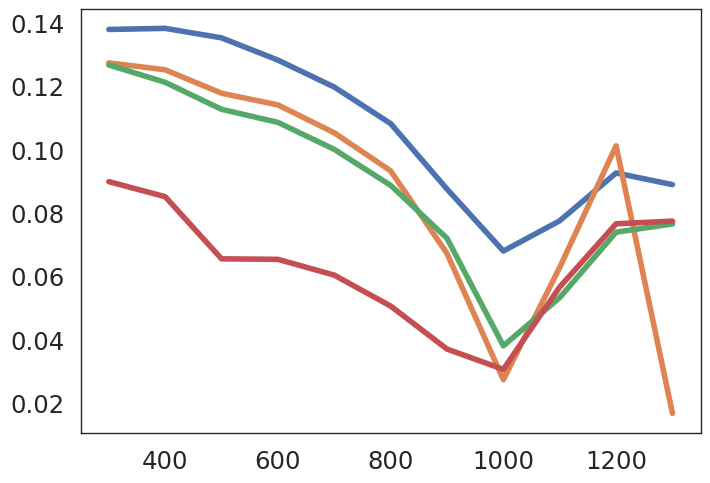

In [48]:
plt.plot(tmpr[0],fermi_0pct_heating[1])
plt.plot(tmpr[0],fermi_1pct_heating[1])
plt.plot(tmpr[0],fermi_5pct_heating[1])
plt.plot(tmpr[0],fermi_5pct_cooling[1])

In [49]:
def compute_fermi_distributions(fermi_levels, energy, temp):
    """
    Compute Fermi distributions for a list of Fermi levels.

    Parameters
    ----------
    fermi_levels : list of np.ndarray
        List of Fermi levels for different conditions.
    energy : np.ndarray
        Energy levels.
    temp : np.ndarray
        Temperature range.

    Returns
    -------
    list of np.ndarray
        List of computed Fermi distributions for different conditions.
    """
    return [fermi_distribution(energy=energy, fermi_level=f[1][np.newaxis, :], temp=temp)
            for f in fermi_levels]

def save_fermi_levels(fermi_levels, temps, k_B):
    """
    Save Fermi levels to files with specified paths.

    Parameters
    ----------
    fermi_levels : list of np.ndarray
        List of Fermi levels for different conditions.
    temps : np.ndarray
        Temperature range.
    k_B : float
        Boltzmann constant.
    """
    output_dir = "Output_Files"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    file_paths = [
        "Output_Files/Ef-no-inc.out",
        "Output_Files/Ef-inc-1pct.out",
        "Output_Files/Ef-inc-5pct-dir-up.out",
        "Output_Files/Ef-inc-5pct-dir-down.out"
    ]
    for fermi_level, path in zip(fermi_levels, file_paths):
        np.savetxt(path, fermi_level[1] / temps / k_B)

fermi_levels = [fermi_0pct_heating, fermi_1pct_heating, fermi_5pct_heating, fermi_5pct_cooling]
fermi_distributions = compute_fermi_distributions(fermi_levels, engr, tmpr)

save_fermi_levels(fermi_levels, tmpr, k_B)

In [50]:
# Non-degenerate screening length
def compute_screening_lengths(carriers, temp):
    """
    Compute the non-degenerate screening length for different carrier concentrations.

    Parameters
    ----------
    carriers : list of np.ndarray
        List of carrier concentrations for different conditions.
    temp : np.ndarray
        Temperature range.
    Returns
    -------
    list of np.ndarray
        List of computed screening lengths for different conditions.
    """
    return [np.sqrt(4 * np.pi * dielectric_constant * permittivity_vacuum * k_B / e2C * temp / carrier)
            for carrier in carriers]

carriers = [cc_0pct_heating, cc_1pct_heating, cc_5pct_heating, cc_5pct_cooling]

# Compute screening lengths
screening_lengths = compute_screening_lengths(carriers=carriers, temp=tmpr)
non_degen_screen_len_0pct, non_degen_screen_len_1pct_dir_up, non_degen_screen_len_5pct_dir_up, non_degen_screen_len_5pct_dir_down = screening_lengths

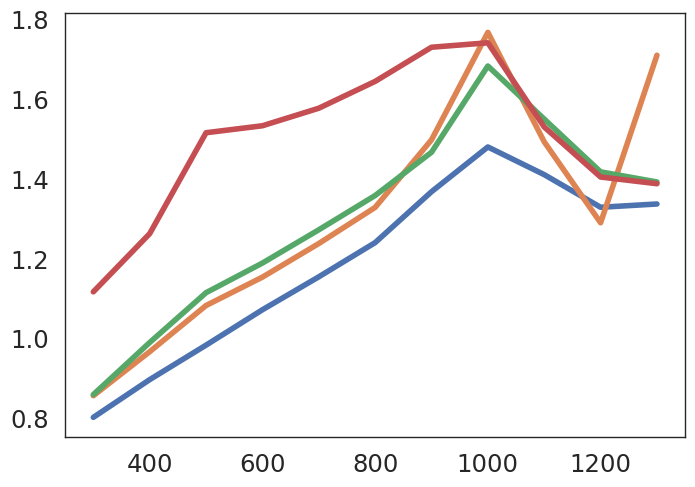

In [51]:
plt.plot(tmpr[0], non_degen_screen_len_0pct[0]*1e9)
plt.plot(tmpr[0], non_degen_screen_len_1pct_dir_up[0]*1e9)
plt.plot(tmpr[0], non_degen_screen_len_5pct_dir_up[0]*1e9)
plt.plot(tmpr[0], non_degen_screen_len_5pct_dir_down[0]*1e9)

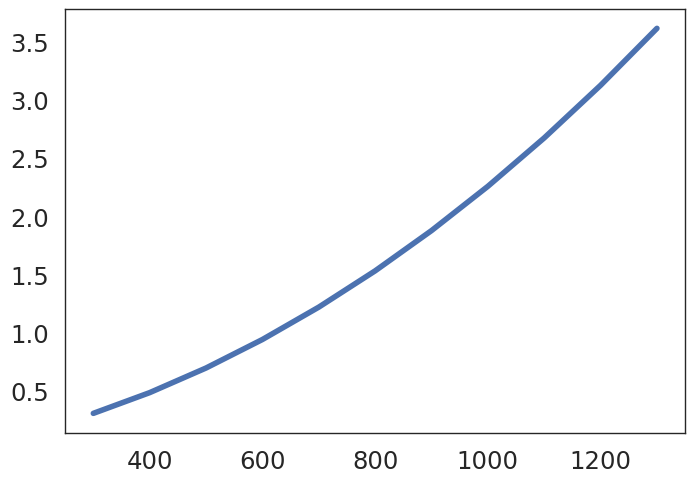

In [52]:
def compute_effective_density_of_states(temp):
    """
    Compute the effective density of states Nc.

    Parameters
    ----------
    temp : np.ndarray
        Temperature range.
    Returns
    -------
    np.ndarray
        Effective density of states Nc.
    """
    return 2 * (mass_cond * k_B * temp / h_bar**2 / (2 * np.pi) / e2C)**(3./2)
mass_cond = 0.23 * electron_mass * (1 + 5 * nonparabolic_term * k_B * tmpr)
Nc = compute_effective_density_of_states(temp=tmpr)
plt.plot(tmpr[0], Nc[0]*1e-25)

In [53]:
# Load Fermi energy levels from files
Ef_0pct = np.loadtxt("Output_Files/Ef-no-inc.out")
Ef_1pct = np.loadtxt("Output_Files/Ef-inc-1pct.out")
Ef_5pct_dir_up = np.loadtxt("Output_Files/Ef-inc-5pct-dir-up.out")
Ef_5pct_dir_down = np.loadtxt("Output_Files/Ef-inc-5pct-dir-down.out")

# Ef_0pct
f1_0pct = [fermi(0.5, eta) for eta in Ef_0pct]
f2_0pct = [fermi(-0.5, eta) for eta in Ef_0pct]
np.savetxt('Output_Files/fermi-0pct.out', np.vstack([f1_0pct, f2_0pct]))

# Ef_1pct
f1_1pct = [fermi(0.5, eta) for eta in Ef_1pct]
f2_1pct = [fermi(-0.5, eta) for eta in Ef_1pct]

np.savetxt('Output_Files/fermi-1pct.out', np.vstack([f1_1pct, f2_1pct]))

# Ef_5pct_dir_up
f1_5pct_dir_up = [fermi(0.5, eta) for eta in Ef_5pct_dir_up]
f2_5pct_dir_up = [fermi(-0.5, eta) for eta in Ef_5pct_dir_up]
np.savetxt('Output_Files/fermi-5pct-dir-up.out', np.vstack([f1_5pct_dir_up, f2_5pct_dir_up]))

# Ef_5pct_dir_down
f1_5pct_dir_down = [fermi(0.5, eta) for eta in Ef_5pct_dir_down]
f2_5pct_dir_down = [fermi(-0.5, eta) for eta in Ef_5pct_dir_down]
np.savetxt('Output_Files/fermi-5pct-dir-down.out', np.vstack([f1_5pct_dir_down, f2_5pct_dir_down]))

In [54]:
def load_fermi_data(file_paths, delimiter=None):
    """
    Load Fermi level data from specified file paths.

    Parameters
    ----------
    file_paths : list of str
        List of file paths to load data from.
    delimiter : str, optional
        Delimiter used in the files (default is ',').

    Returns
    -------
    list of np.ndarray
        Loaded Fermi level data as a list of arrays.
    """
    fermi_data = []
    for path in file_paths:
        try:
            data = np.loadtxt(path, delimiter=delimiter)
            fermi_data.append(data)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return fermi_data

# Define file paths for the Fermi level data
fermi_file_paths = [
    "Output_Files/fermi-0pct.out",
    "Output_Files/fermi-1pct.out",
    "Output_Files/fermi-5pct-dir-up.out",
    "Output_Files/fermi-5pct-dir-down.out"
    ]
# Load Fermi level data
fermi_0pct, fermi_1pct, fermi_5pct_dir_up, fermi_5pct_dir_down = load_fermi_data(fermi_file_paths)

In [55]:
# Degenerate screening length
def calculate_screening_length(Nc, tmpr, fermi):
    """
    Calculate the screening length for a given set of parameters.

    Parameters
    ----------
    Nc : float
        Effective density of states in the conduction band.
    tmpr : float
        Temperature.
    fermi : np.ndarray
        Fermi level data, with [0] being the Fermi energy and [1] the carrier concentration.

    Returns
    -------
    float
        Screening length.
    """
    _ = fermi[1] + 15 * nonparabolic_term * k_B * tmpr / (4 * fermi[0])
    screening_length = np.sqrt(1 / (Nc / dielectric_constant / permittivity_vacuum / k_B / tmpr * e2C * _))

    return screening_length

screen_len_0pct = calculate_screening_length(Nc, tmpr, fermi_0pct)
screen_len_1pct = calculate_screening_length(Nc, tmpr, fermi_1pct)
screen_len_5pct_dir_up = calculate_screening_length(Nc, tmpr, fermi_5pct_dir_up)
screen_len_5pct_dir_down = calculate_screening_length(Nc, tmpr, fermi_5pct_dir_down)

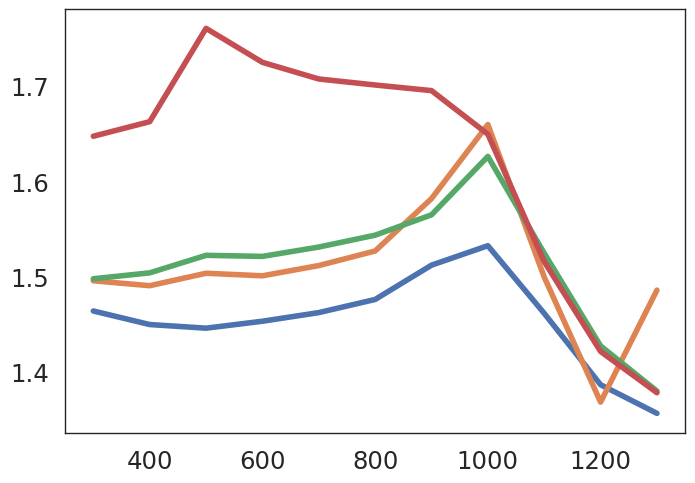

In [56]:
plt.plot(tmpr[0], screen_len_0pct[0]*1e9)
plt.plot(tmpr[0], screen_len_1pct[0]*1e9)
plt.plot(tmpr[0], screen_len_5pct_dir_up[0]*1e9)
plt.plot(tmpr[0], screen_len_5pct_dir_down[0]*1e9)

### Lifetimes

#### Phonon Scattering

In [57]:
lifetime_phonon = calculate_phonon_lifetime(energy=engr, alpha_term=nonparabolic_term,
                                   D_v=2.94, D_a=9.5, temperature=tmpr,
                                   sound_velocity=speed_of_sound, density_of_states=e_density,
                                   mass_density = density)

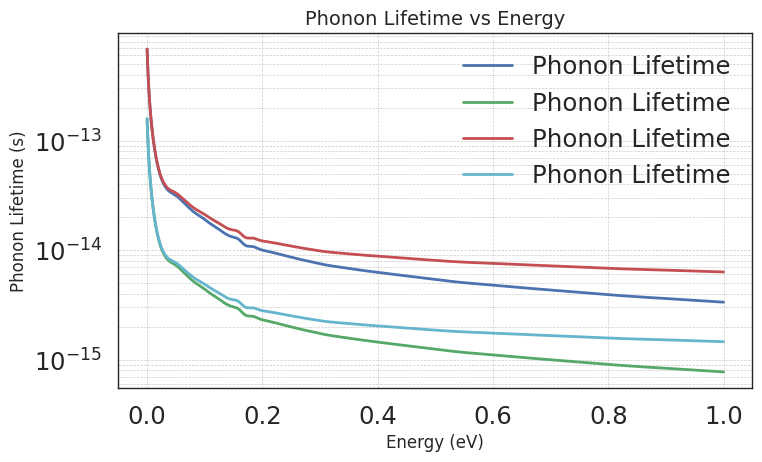

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(engr[0], lifetime_phonon['parabolic_phonon_lifetime'][0], label='Phonon Lifetime', color='b', linestyle='-', linewidth=2)
plt.plot(engr[0], lifetime_phonon['parabolic_phonon_lifetime'][-1], label='Phonon Lifetime', color='g', linestyle='-', linewidth=2)
plt.plot(engr[0], lifetime_phonon['nonparabolic_phonon_lifetime'][0], label='Phonon Lifetime', color='r', linestyle='-', linewidth=2)
plt.plot(engr[0], lifetime_phonon['nonparabolic_phonon_lifetime'][-1], label='Phonon Lifetime', color='c', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Energy (eV)', fontsize=12)
plt.ylabel('Phonon Lifetime (s)', fontsize=12)
plt.title('Phonon Lifetime vs Energy', fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

#### Impurities Scattering

In [59]:
def calculate_impurity_lifetimes(density_of_states, screening_lengths, impurity_scatterings, dielectric_constant):
    """
    Calculate screened Coulomb lifetimes for different SiC fractions during heating and cooling.

    Parameters
    ----------
    density_of_states : np.ndarray
        Electron density of states.
    screening_lengths : dict
        Dictionary of screening lengths for different SiC fractions.
    impurity_scatterings : dict
        Dictionary of impurity scatterings for different SiC fractions.
    dielectric_constant : float
        Dielectric constant of the material.

    Returns
    -------
    dict
        Screened Coulomb lifetimes for different SiC fractions.
    """
    lifetimes = {}

    for fraction, screening_length in screening_lengths.items():
        lifetimes[f'tau_imp_{fraction}'] = calculate_screened_coulomb_lifetime(
            density_of_states=density_of_states,
            screening_length=screening_length,
            impurity_scattering=impurity_scatterings[fraction],
            dielectric_constant=dielectric_constant
        )

    return lifetimes


# Define screening lengths and impurity scatterings for different fractions
screening_lengths = {
    '0pct': screen_len_0pct,
    '1pct': screen_len_1pct,
    '5pct_heating': screen_len_5pct_dir_up,
    '5pct_cooling': screen_len_5pct_dir_down
    }

impurity_scatterings = {
    '0pct': cc_0pct_heating,
    '1pct': cc_1pct_heating,
    '5pct_heating': cc_5pct_heating,
    '5pct_cooling': cc_5pct_cooling
    }

# Calculate impurity lifetimes for all fractions
impurity_lifetimes = calculate_impurity_lifetimes(
    density_of_states=e_density,
    screening_lengths=screening_lengths,
    impurity_scatterings=impurity_scatterings,
    dielectric_constant=dielectric_constant
    )

tau_imp_0pct = impurity_lifetimes['tau_imp_0pct']
tau_imp_1pct = impurity_lifetimes['tau_imp_1pct']
tau_imp_5pct_heating = impurity_lifetimes['tau_imp_5pct_heating']
tau_imp_5pct_cooling = impurity_lifetimes['tau_imp_5pct_cooling']

#### Grain Boundary Scattering

In [60]:
# N_gr = 1e25  # Traps concentration [#/m^2]
# _tau_gb = np.loadtxt('Lifetime_Data/lifetime_grain.out', delimiter=None, skiprows=0, max_rows=1)
# _engr_gb = np.loadtxt('Lifetime_Data/energy_grain.out', delimiter=None, skiprows=0)
# energy_gb, idx_energy_gb, rtrn_idx_energy_gb = np.unique(_engr_gb, return_index=True, return_inverse=True)
# tau_gb_accum = accum(rtrn_idx_energy_gb, _tau_gb, func=np.mean, dtype=float)
# tau_gb_interpolator  = Interpolator(energy_gb[1::], tau_gb_accum[1::])
# tau_gb = tau_gb_interpolator(engr) * (fermi_0pct_heating[0] / N_gr)[:, np.newaxis]

#### Nanoparticles Scattering

In [74]:
m_frac = np.array([0.89,0.19,0.19])                               # Si electron effective mass ratio
ko = 2 * np.pi / lattice_parameter * np.array([0.85,0,0])         # Si conduction band valley along (1/m)
del_k = 2 * np.pi / lattice_parameter * 0.15 * np.array([1,1,1])  # Si brillouin zone edge from valley
uo = 1.389                                                        # SiC barrier height (eV)
v_frac = 0.05                                                     # SiC Volume fraction
n = 23                                                            # Number of points for meshing elipsoid
_nk = 4
nk = np.array([_nk,_nk,_nk])                                      # Number of kpoints along x y z

##### Spherical Particles

In [62]:
ro = 3e-9                                                         # Spherical particles radius (m)
tau_spherical_particles = calculate_finite_spherical_scattering(ro, nk, uo, m_frac, v_frac,
                                                                ko, del_k, n, engr)

Processing energies:   0%|          | 0/729 [00:00<?, ?it/s]<ipython-input-27-8bb6fc4f6f85>:62: RuntimeWarning: divide by zero encountered in divide
  M = 4 * np.pi * uo * (1.0 / q * np.sin(ro * q) - ro * np.cos(ro * q)) / q**2
<ipython-input-27-8bb6fc4f6f85>:62: RuntimeWarning: invalid value encountered in multiply
  M = 4 * np.pi * uo * (1.0 / q * np.sin(ro * q) - ro * np.cos(ro * q)) / q**2
Processing energies: 100%|██████████| 729/729 [00:30<00:00, 24.10it/s]


##### Clyndrical Particles

In [68]:
ho = 4/3 * ro                                                     # Clyndrical particles height (m)
tau_cylindrical_particles = calculate_finite_cylindrical_scattering(ho, ro, nk, uo, m_frac, v_frac,
                                                                   ko, del_k, n, engr)

Processing energies:   0%|          | 0/729 [00:00<?, ?it/s]<ipython-input-64-7ab834ba4929>:64: RuntimeWarning: divide by zero encountered in divide
  M = 4 * np.pi * uo * ro * J / qr * (np.sin(ho * qz / 2) / qz)
<ipython-input-64-7ab834ba4929>:64: RuntimeWarning: invalid value encountered in divide
  M = 4 * np.pi * uo * ro * J / qr * (np.sin(ho * qz / 2) / qz)
Processing energies: 100%|██████████| 729/729 [00:29<00:00, 24.53it/s]


##### Cubic Particles

In [132]:
len = (4/3 * np.pi * ro**3)**(1/3) * np.array([1,1,1])           # Cubic particles length (m)
tau_cubic_particles = calculate_finite_cubic_scattering(len, nk, uo, m_frac, v_frac,
                                                        ko, del_k, n, engr)

Processing energies:   0%|          | 0/64 [00:00<?, ?it/s]<ipython-input-131-eedeb3b7322b>:59: RuntimeWarning: invalid value encountered in divide
  M = 8 * uo * (np.sin(len[0] * qx / 2) / qx) * \
<ipython-input-131-eedeb3b7322b>:60: RuntimeWarning: invalid value encountered in divide
  (np.sin(len[1] * qy / 2) / qy) * \
<ipython-input-131-eedeb3b7322b>:61: RuntimeWarning: invalid value encountered in divide
  (np.sin(len[2] * qz / 2) / qz)
Processing energies: 100%|██████████| 64/64 [00:03<00:00, 16.25it/s]


In [133]:
tau_cubic_particles

array([[1.64414263e-12, 1.63907356e-12, 1.63401429e-12, ...,
        8.82883562e-14, 8.81795073e-14, 8.80715468e-14]])

In [ ]:
_tau_np = np.loadtxt('Lifetime_Data/lifetime_np.out', delimiter=None, skiprows=0)
_engr_np = np.loadtxt('Lifetime_Data/energy_np.out', delimiter=None, skiprows=0)

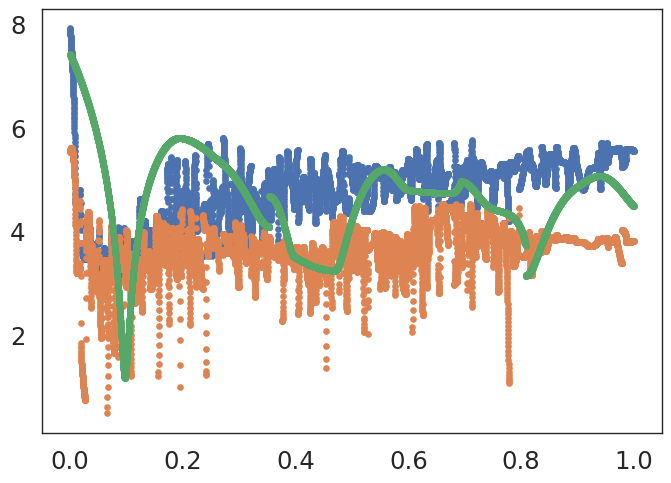

In [135]:
plt.plot(engr[0], np.log(tau_spherical_particles[0]*1e15), 'o')
plt.plot(engr[0], np.log(tau_cylindrical_particles[0]*1e15), 'o')
plt.plot(engr[0], np.log(tau_cubic_particles[0]*1e15), 'o')
# plt.plot(_engr_np, np.log(_tau_np[2]), 'o')

In [ ]:
_tau_np = np.loadtxt('Lifetime_Data/lifetime_np.out', delimiter=None, skiprows=0)
_engr_np = np.loadtxt('Lifetime_Data/energy_np.out', delimiter=None, skiprows=0)

energy_np, idx_energy_np, rtrn_idx_energy_np = np.unique(_engr_np, return_index = True, return_inverse = True)
tau_np_accum = accum(rtrn_idx_energy_np, _tau_np[1], func = np.mean, dtype = float)
tau_np_interpolator = Interpolator(energy_np[1:], tau_np_accum[1:])
tau_np = tau_np_interpolator(engr)

#### Extended Particles

In [140]:
ro = 4*1e-9 # Cylinder radius (m)
nt = int(1e4)
k_magnitude, E, relaxation_time, num_particles = calculate_inf_cylinder_scattering(radius= ro, k_points=nk, potential=uo,
                                                                                   mass_fraction=m_frac, volume_fraction=v_frac,
                                                                                   initial_wave_vector=ko, delta_k_vector=del_k,
                                                                                   num_divisions=nt)

<ipython-input-138-034298b3b83f>:76: RuntimeWarning: invalid value encountered in divide
  cos_theta = (kx_cos_t * k_point_matrix[:, 0, np.newaxis] +
<ipython-input-138-034298b3b83f>:101: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  integrated_func = trapz(func, t, axis=1)


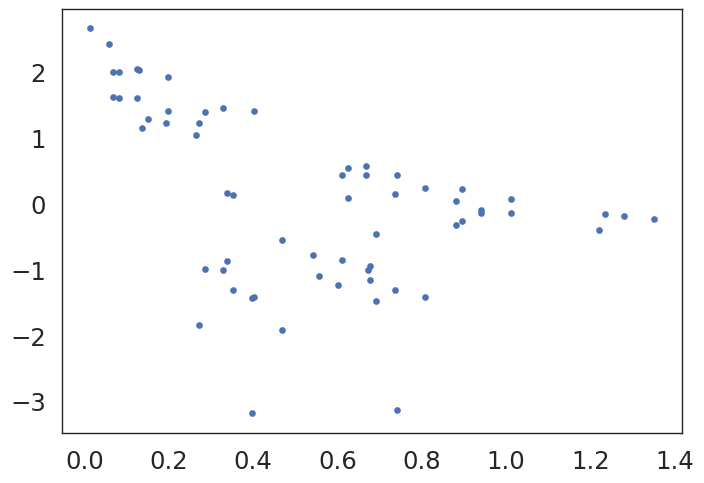

In [146]:
plt.plot(E, np.log(relaxation_time*1e12),'o')

In [143]:
relaxation_time

array([           nan, 5.04352553e-12, 1.57511690e-13, 4.24214657e-13,
       1.43701377e-11, 4.97946884e-12, 3.71761044e-13, 1.08960167e-12,
       1.12435511e-11, 5.00116951e-12, 3.66325009e-13, 1.78286028e-12,
       7.67773628e-12, 4.09255170e-12, 2.40684102e-13, 1.55377315e-12,
       7.36104456e-12, 3.15137094e-12, 4.16937694e-13, 3.85872180e-13,
       7.40599252e-12, 3.60361094e-12, 2.68193223e-13, 6.31412079e-13,
       7.75158462e-12, 3.41452245e-12, 2.39283074e-13, 1.15588381e-12,
       6.86226436e-12, 2.85393506e-12, 5.73377952e-13, 1.27488036e-12,
       3.41666216e-12, 1.18092946e-12, 4.56820160e-13, 1.03836261e-12,
       4.01645337e-12, 1.13436280e-12, 3.31537004e-13, 1.24223152e-12,
       4.25320330e-12, 4.12011023e-14, 2.88487714e-13, 9.03731291e-13,
       4.07464247e-12, 1.46317344e-13, 3.63667684e-13, 1.06760038e-12,
       1.55698923e-12, 3.11719210e-13, 7.18307544e-13, 6.66926213e-13,
       1.71881010e-12, 2.25980282e-13, 7.68485041e-13, 8.49358754e-13,
      

### Compute Properties

In [ ]:
num_vally = 6

tau_0pct = matthiessen(engr, num_vally * tau_ph['nonparabolic_ph_lifetime'], num_vally * tau_imp_0pct, tau_gb)
tau_5pct_dir_up = matthiessen(engr, num_vally * tau_ph['nonparabolic_ph_lifetime'], num_vally * tau_imp_5pct_dir_up, tau_gb)
tau_5pct_dir_down = matthiessen(engr, num_vally * tau_ph['nonparabolic_ph_lifetime'], num_vally * tau_imp_5pct_dir_down, tau_gb)
tau_1pct = matthiessen(engr, num_vally * tau_ph['nonparabolic_ph_lifetime'], num_vally * tau_imp_1pct, 5 * tau_gb)  # 5 counts for 1% porosity instead of 5%

prop_0pct = electrical_properties(E = engr, DoS = e_density, vg = grp_velocity, Ef = fermi_0pct_heating[1][np.newaxis, :],
                                  dfdE=fermi_dist_0pct_heating[1], temp = tmpr, tau = tau_0pct)
prop_1pct = electrical_properties(E = engr, DoS = e_density, vg = grp_velocity, Ef = fermi_1pct_heating[1][np.newaxis, :],
                                  dfdE=fermi_dist_1pct_heating[1], temp = tmpr, tau = tau_1pct)
prop_5pct_dir_up = electrical_properties(E = engr, DoS = e_density, vg = grp_velocity, Ef = fermi_5pct_heating[1][np.newaxis, :],
                                         dfdE=fermi_dist_5pct_heating[1], temp = tmpr, tau = tau_0pct)
prop_5pct_dir_down = electrical_properties(E = engr, DoS = e_density, vg = grp_velocity, Ef = fermi_5pct_cooling[1][np.newaxis, :],
                                           dfdE=fermi_dist_5pct_cooling[1], temp = tmpr, tau = tau_0pct)


exec(open('./figs.py').read())

exit()

